In [1]:
import pandas as pd
import numpy as np
import pickle
import multiprocessing
from time import time
from math import sqrt
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import xgboost
from xgboost.sklearn import XGBClassifier
from xgboost import plot_importance
import shap
import warnings
warnings.simplefilter("ignore")

%matplotlib inline

In [2]:
shap.initjs()

In [3]:
df = pd.read_csv('../data/tweets&sentiment&absoluteprices&topics.csv', index_col=0)

In [4]:
df.shape

(26231, 29)

In [5]:
df.head()

source                                               text  \
0  Twitter for iPhone  Thank you @HerschelWalker! https://t.co/XjlYe8...   
1  Twitter for iPhone  RT @GOPChairwoman: Big news!A Maine court side...   
2  Twitter for iPhone            Thank you Paul! https://t.co/aAk1sfww0d   
3  Twitter for iPhone  100000 DEFECTIVE BALLOTS IN NEW YORK. THEY WAN...   
4  Twitter for iPhone  In just 3 and a half years we have secured Ame...   

                                        cleaned_text           created_at  \
0                                              thank  2020-09-30 23:45:25   
1  big news maine court side rnc uphold ban ballo...  2020-09-30 23:25:31   
2                                         thank paul  2020-09-30 23:00:33   
3  defective ballot new york want replace happen ...  2020-09-30 22:59:02   
4  half years secure americas border rebuild awes...  2020-09-30 22:51:05   

   retweet_count  favorite_count  is_retweet               id_str    hashtag  \
0          19616           65721       False  1311512518800470016         []   
1          29393               0        True  1311507509958471680         []   
2          15992           63294       False  1311501225423073281         []   
3          51445          190750       False  1311500843309387781         []   
4          18885           70838       False  1311498845860196355  ['#MAGA']   

               mention  ...  pos_sentiment  compound_sentiment  created_date  \
0  ['@HerschelWalker']  ...          1.000              0.4199    2020-09-30   
1                   []  ...          0.000              0.0000    2020-09-30   
2                   []  ...          0.736              0.4199    2020-09-30   
3                   []  ...          0.028             -0.7988    2020-09-30   
4                   []  ...          0.188             -0.1260    2020-09-30   

   created_time  passed_closing  market_date        ^GSPC         ^IXIC  \
0      23:45:25               1   2020-10-01  3380.800049  11326.509766   
1      23:25:31               1   2020-10-01  3380.800049  11326.509766   
2      23:00:33               1   2020-10-01  3380.800049  11326.509766   
3      22:59:02               1   2020-10-01  3380.800049  11326.509766   
4      22:51:05               1   2020-10-01  3380.800049  11326.509766   

          VGT  topic  
0  315.329987      6  
1  315.329987      2  
2  315.329987      6  
3  315.329987      6  
4  315.329987      7  

[5 rows x 29 columns]

# Feature preprocessing

## Drop features

In this step, features not useful for modelling are discarded. Such features are:
* source
* text
* created_at
* id_str
* hashtag
* mention
* neg_sentiment
* neu_sentiment
* pos_sentiment
* created_date
* created_time
* passed_closing
* market_date

In [6]:
# drop review_no, product_id and review_date
df = df.drop(columns=['source', 'text', 'created_at', 'id_str', 'hashtag', 'mention', 
                      'neg_sentiment', 'neu_sentiment', 'pos_sentiment', 'created_date',
                      'created_time', 'passed_closing'
                     ], errors='ignore')

In [7]:
df.columns

Index(['cleaned_text', 'retweet_count', 'favorite_count', 'is_retweet',
       'hashtag_count', 'mention_count', 'word_count', 'char_count',
       'word_density', 'punctuation_freq', 'upper_case_freq',
       'compound_sentiment', 'market_date', '^GSPC', '^IXIC', 'VGT', 'topic'],
      dtype='object')

## Type casting

In [8]:
df.dtypes

cleaned_text           object
retweet_count           int64
favorite_count          int64
is_retweet               bool
hashtag_count           int64
mention_count           int64
word_count              int64
char_count              int64
word_density          float64
punctuation_freq      float64
upper_case_freq       float64
compound_sentiment    float64
market_date            object
^GSPC                 float64
^IXIC                 float64
VGT                   float64
topic                   int64
dtype: object

In [9]:
# change is_tweet from boolean to binary
df['is_retweet'] = df['is_retweet'].replace({True:1, False:0})

## Prepare different feature sets for modelling
There are different sets of features that we would like to test on the XGBoost model and the deep learning model. The figure below summaries these different feature sets. This notebook will focus on XGBoost model, for which three feature sets will be used. The purpose of using different sets of features is to investigate whether the inclusion of word embedding and topic modellling will help improve the prediction accuracy. 

<img src="https://i.ibb.co/KyxdpY5/feature-sets.png" align="left" width="800">

In [10]:
# train is 75% of the entire data set
# set the same random seed for fairer comparison across different feature sets
TRAIN_RATIO = 0.75
RANDOM_STATE = 1

### Feature set 1: Meta text features
In this feature set, only meta text features e.g. word count, punctuation frequency, are used to predict the stock prices

#### Drop features

In [11]:
set1_df = df.drop(columns=['cleaned_text', 'cleaned_text_w2v', 'topic', 'compound_sentiment'], errors='ignore')

In [12]:
set1_df.columns

Index(['retweet_count', 'favorite_count', 'is_retweet', 'hashtag_count',
       'mention_count', 'word_count', 'char_count', 'word_density',
       'punctuation_freq', 'upper_case_freq', 'market_date', '^GSPC', '^IXIC',
       'VGT'],
      dtype='object')

#### Group by day

In [13]:
set1_df_grouped = set1_df.groupby('market_date').mean()
set1_df_grouped

retweet_count  favorite_count  is_retweet  hashtag_count  \
market_date                                                             
2016-01-04     2660.326087     6782.043478    0.021739       0.369565   
2016-01-05     1311.800000     3935.666667    0.000000       0.200000   
2016-01-06     2070.187500     5250.812500    0.000000       0.187500   
2016-01-07     2320.153846     4770.153846    0.076923       0.000000   
2016-01-08     1755.272727     5410.545455    0.000000       0.181818   
...                    ...             ...         ...            ...   
2020-09-25    11027.592593    17052.987654    0.728395       0.160494   
2020-09-28    18093.602740    48695.178082    0.602740       0.068493   
2020-09-29    18839.086957    40977.739130    0.565217       0.217391   
2020-09-30    16094.241379    39945.931034    0.413793       0.068966   
2020-10-01    22670.476190    68784.428571    0.285714       0.142857   

             mention_count  word_count  char_count  word_density  \
market_date                                                        
2016-01-04        0.847826   25.434783  125.586957      5.041834   
2016-01-05        1.933333   23.933333  125.066667      5.315622   
2016-01-06        1.812500   22.312500  115.125000      5.171109   
2016-01-07        0.615385   24.307692  119.384615      4.932159   
2016-01-08        1.272727   21.090909  103.000000      4.857924   
...                    ...         ...         ...           ...   
2020-09-25        0.283951   24.407407  131.555556      5.362159   
2020-09-28        0.328767   26.013699  140.561644      5.393996   
2020-09-29        0.478261   21.869565  117.826087      5.362086   
2020-09-30        0.068966   21.603448  112.706897      5.156863   
2020-10-01        0.142857   29.190476  150.666667      5.139609   

             punctuation_freq  upper_case_freq        ^GSPC         ^IXIC  \
market_date                                                                 
2016-01-04           0.264225         0.040537  2012.660034   4903.089844   
2016-01-05           0.369321         0.068486  2016.709961   4891.430176   
2016-01-06           0.328001         0.049176  1990.260010   4835.759766   
2016-01-07           0.196628         0.061658  1943.089966   4689.430176   
2016-01-08           0.233505         0.023726  1922.030029   4643.629883   
...                       ...              ...          ...           ...   
2020-09-25           0.208298         0.105256  3298.459961  10913.559570   
2020-09-28           0.193178         0.112667  3351.600098  11117.530273   
2020-09-29           0.232904         0.098861  3335.469971  11085.250000   
2020-09-30           0.201289         0.066350  3363.000000  11167.509766   
2020-10-01           0.186691         0.149118  3380.800049  11326.509766   

                    VGT  
market_date              
2016-01-04   100.618843  
2016-01-05   100.137505  
2016-01-06    98.778427  
2016-01-07    95.597809  
2016-01-08    94.776695  
...                 ...  
2020-09-25   304.359985  
2020-09-28   310.000000  
2020-09-29   309.149994  
2020-09-30   311.450012  
2020-10-01   315.329987  

[1186 rows x 13 columns]

#### Correlation plot

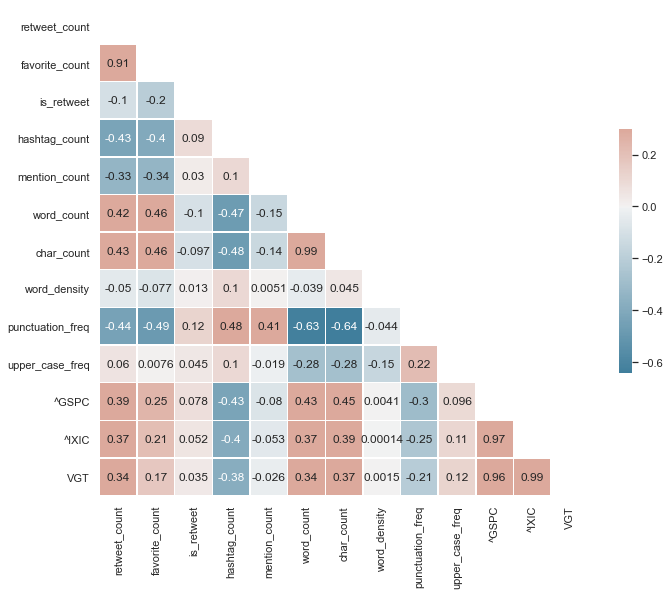

In [28]:
sns.set_theme(style="white")

# Compute the correlation matrix
corr = set1_df_grouped.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot = True)

plt.savefig("../plots/feature_set_1/correlation_plot.png", dpi=300, bbox_inches='tight')
plt.show()

#### Train test split

In [17]:
# target variables
set1_y_GSPC = set1_df_grouped['^GSPC']
set1_y_IXIC = set1_df_grouped['^IXIC']
set1_y_VGT = set1_df_grouped['VGT']

# features
set1_X = set1_df_grouped.drop(columns=['^GSPC', '^IXIC', 'VGT', 'market_date'], errors='ignore')
set1_X.shape

(1186, 10)

In [18]:
# GSPC
set1_X_train_GSPC, set1_X_test_GSPC, set1_y_train_GSPC, set1_y_test_GSPC = train_test_split(set1_X, set1_y_GSPC, 
                                                                                            test_size=1-TRAIN_RATIO, 
                                                                                            random_state=RANDOM_STATE)

# IXIC
set1_X_train_IXIC, set1_X_test_IXIC, set1_y_train_IXIC, set1_y_test_IXIC = train_test_split(set1_X, set1_y_IXIC, 
                                                                                            test_size=1-TRAIN_RATIO, 
                                                                                            random_state=RANDOM_STATE)

# VGT
set1_X_train_VGT, set1_X_test_VGT, set1_y_train_VGT, set1_y_test_VGT = train_test_split(set1_X, set1_y_VGT, 
                                                                                        test_size=1-TRAIN_RATIO, 
                                                                                        random_state=RANDOM_STATE)

### Feature set 2: Meta text features + topic-based sentiment scores
In this feature set, we supplement the the meta text features with topic-based sentiment scores. Topic of a tweet is obtained from running topic modelling at the preprocessing stage. Likewise, sentiment of a tweet is obtained via sentiment analysis using VADER.
<br>
There are in total 10 topics. For the topic that a tweet is in, its sentiment score will be attached to that topic. The sentiment scores for the remaining 9 topics are 0.

#### Get dummies for topic-based sentiment

In [19]:
dummies = pd.get_dummies(df['topic'])

In [20]:
topic_based_sentiment = pd.DataFrame()

In [21]:
for col in dummies.columns:
    topic_based_sentiment[col] = dummies[col]*df['compound_sentiment']

In [22]:
topic_based_sentiment.columns = ['topic1', 'topic2', 'topic3', 'topic4', 'topic5','topic6', 'topic7', 'topic8', 'topic9', 'topic10']

In [23]:
topic_based_sentiment.head()

topic1  topic2  topic3  topic4  topic5  topic6  topic7  topic8  topic9  \
0     0.0     0.0     0.0     0.0     0.0  0.4199   0.000     0.0     0.0   
1     0.0     0.0     0.0     0.0     0.0  0.0000   0.000     0.0     0.0   
2     0.0     0.0     0.0     0.0     0.0  0.4199   0.000     0.0     0.0   
3    -0.0    -0.0    -0.0    -0.0    -0.0 -0.7988  -0.000    -0.0    -0.0   
4    -0.0    -0.0    -0.0    -0.0    -0.0 -0.0000  -0.126    -0.0    -0.0   

   topic10  
0      0.0  
1      0.0  
2      0.0  
3     -0.0  
4     -0.0

#### Concatenate meta text features to form the second features set

In [24]:
set2_df = pd.concat([set1_df, topic_based_sentiment], axis=1)
set2_df.head()

retweet_count  favorite_count  is_retweet  hashtag_count  mention_count  \
0          19616           65721           0              0              1   
1          29393               0           1              0              0   
2          15992           63294           0              0              0   
3          51445          190750           0              0              0   
4          18885           70838           0              1              0   

   word_count  char_count  word_density  punctuation_freq  upper_case_freq  \
0           5          28      5.600000          0.400000         0.000000   
1          24         138      5.750000          0.291667         0.166667   
2           4          16      4.000000          0.250000         0.000000   
3          42         199      4.738095          0.119048         0.857143   
4          43         239      5.558140          0.093023         0.116279   

   ... topic1  topic2  topic3  topic4  topic5  topic6  topic7  topic8  topic9  \
0  ...    0.0     0.0     0.0     0.0     0.0  0.4199   0.000     0.0     0.0   
1  ...    0.0     0.0     0.0     0.0     0.0  0.0000   0.000     0.0     0.0   
2  ...    0.0     0.0     0.0     0.0     0.0  0.4199   0.000     0.0     0.0   
3  ...   -0.0    -0.0    -0.0    -0.0    -0.0 -0.7988  -0.000    -0.0    -0.0   
4  ...   -0.0    -0.0    -0.0    -0.0    -0.0 -0.0000  -0.126    -0.0    -0.0   

   topic10  
0      0.0  
1      0.0  
2      0.0  
3     -0.0  
4     -0.0  

[5 rows x 24 columns]

#### Group by day

In [25]:
set2_df_grouped = set2_df.groupby('market_date').mean()
set2_df_grouped

retweet_count  favorite_count  is_retweet  hashtag_count  \
market_date                                                             
2016-01-04     2660.326087     6782.043478    0.021739       0.369565   
2016-01-05     1311.800000     3935.666667    0.000000       0.200000   
2016-01-06     2070.187500     5250.812500    0.000000       0.187500   
2016-01-07     2320.153846     4770.153846    0.076923       0.000000   
2016-01-08     1755.272727     5410.545455    0.000000       0.181818   
...                    ...             ...         ...            ...   
2020-09-25    11027.592593    17052.987654    0.728395       0.160494   
2020-09-28    18093.602740    48695.178082    0.602740       0.068493   
2020-09-29    18839.086957    40977.739130    0.565217       0.217391   
2020-09-30    16094.241379    39945.931034    0.413793       0.068966   
2020-10-01    22670.476190    68784.428571    0.285714       0.142857   

             mention_count  word_count  char_count  word_density  \
market_date                                                        
2016-01-04        0.847826   25.434783  125.586957      5.041834   
2016-01-05        1.933333   23.933333  125.066667      5.315622   
2016-01-06        1.812500   22.312500  115.125000      5.171109   
2016-01-07        0.615385   24.307692  119.384615      4.932159   
2016-01-08        1.272727   21.090909  103.000000      4.857924   
...                    ...         ...         ...           ...   
2020-09-25        0.283951   24.407407  131.555556      5.362159   
2020-09-28        0.328767   26.013699  140.561644      5.393996   
2020-09-29        0.478261   21.869565  117.826087      5.362086   
2020-09-30        0.068966   21.603448  112.706897      5.156863   
2020-10-01        0.142857   29.190476  150.666667      5.139609   

             punctuation_freq  upper_case_freq  ...    topic1    topic2  \
market_date                                     ...                       
2016-01-04           0.264225         0.040537  ...  0.000000  0.137824   
2016-01-05           0.369321         0.068486  ...  0.000000  0.109420   
2016-01-06           0.328001         0.049176  ...  0.000000  0.086437   
2016-01-07           0.196628         0.061658  ...  0.059823  0.035123   
2016-01-08           0.233505         0.023726  ...  0.000000  0.000000   
...                       ...              ...  ...       ...       ...   
2020-09-25           0.208298         0.105256  ...  0.000000  0.084502   
2020-09-28           0.193178         0.112667  ...  0.000033  0.059605   
2020-09-29           0.232904         0.098861  ...  0.000000  0.100278   
2020-09-30           0.201289         0.066350  ... -0.009350 -0.008759   
2020-10-01           0.186691         0.149118  ...  0.000000  0.042514   

               topic3    topic4    topic5    topic6    topic7  topic8  \
market_date                                                             
2016-01-04   0.000000  0.000000  0.000000  0.098361 -0.060667     0.0   
2016-01-05   0.000000  0.000000  0.000000  0.280087  0.032493     0.0   
2016-01-06   0.000000  0.000000  0.000000 -0.073081  0.055044     0.0   
2016-01-07   0.000000  0.000000  0.000000 -0.133877  0.000000     0.0   
2016-01-08   0.000000  0.000000  0.000000  0.086091  0.057318     0.0   
...               ...       ...       ...       ...       ...     ...   
2020-09-25   0.011415 -0.021478 -0.010517  0.016368  0.046552     0.0   
2020-09-28   0.036719  0.000000  0.164732  0.088053 -0.009136     0.0   
2020-09-29  -0.024865  0.000000  0.000000  0.043148 -0.018257     0.0   
2020-09-30   0.000000  0.000000  0.000000 -0.121560  0.054009     0.0   
2020-10-01   0.000000  0.000000  0.000000 -0.079824 -0.021152     0.0   

               topic9   topic10  
market_date                      
2016-01-04   0.000000  0.000000  
2016-01-05   0.000000  0.000000  
2016-01-06   0.000000  0.053494  
2016-01-07   0.041715  0.000000  
2016-01-08   0.000000  0.000000  
...           

#### Correlation plot

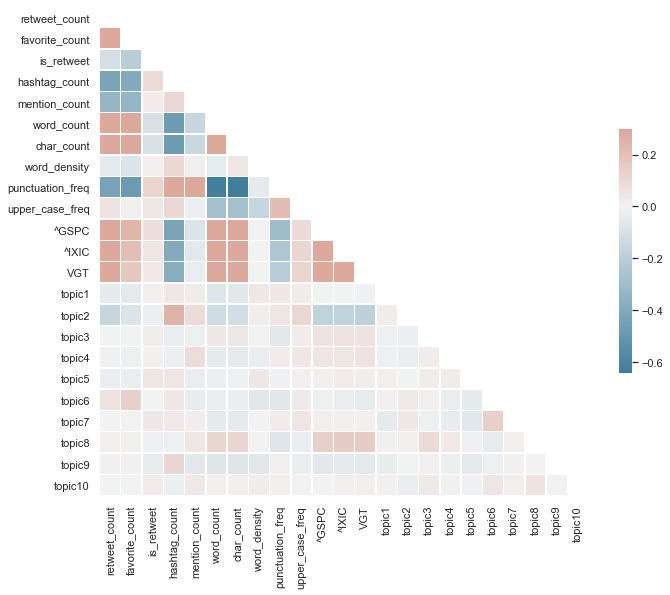

In [27]:
sns.set_theme(style="white")

# Compute the correlation matrix
corr = set2_df_grouped.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot = False)

plt.savefig("../plots/feature_set_2/correlation_plot.png", dpi=300, bbox_inches='tight')
plt.show()

#### Train test split

In [29]:
# target variables
set2_y_GSPC = set2_df_grouped['^GSPC']
set2_y_IXIC = set2_df_grouped['^IXIC']
set2_y_VGT = set2_df_grouped['VGT']

# features
set2_X = set2_df_grouped.drop(columns=['^GSPC', '^IXIC', 'VGT'], errors='ignore')
set2_X.shape

(1186, 20)

In [30]:
# GSPC
set2_X_train_GSPC, set2_X_test_GSPC, set2_y_train_GSPC, set2_y_test_GSPC = train_test_split(set2_X, set2_y_GSPC, 
                                                                                            test_size=1-TRAIN_RATIO, 
                                                                                            random_state=RANDOM_STATE)

# IXIC
set2_X_train_IXIC, set2_X_test_IXIC, set2_y_train_IXIC, set2_y_test_IXIC = train_test_split(set2_X, set2_y_IXIC, 
                                                                                            test_size=1-TRAIN_RATIO, 
                                                                                            random_state=RANDOM_STATE)

# VGT
set2_X_train_VGT, set2_X_test_VGT, set2_y_train_VGT, set2_y_test_VGT = train_test_split(set2_X, set2_y_VGT, 
                                                                                        test_size=1-TRAIN_RATIO, 
                                                                                        random_state=RANDOM_STATE)

### Feature set 3: Meta text features + topic-based sentiment scores + word embedding
In this feature set, we supplement the previous features set with word embeddings obtained from data preprocessing. Word2Vec is used as the chosen embedding method. For more information on the implementation details of the word embedding algorithm, refer to the notebook titled `word embeddings.ipynb`

#### Retrieve word embedding vectors

In [31]:
w2v_embeddings_train = pd.read_csv('../model/word2vec/word2vec_train.csv')

#### Concatenate word embedding with other features

In [32]:
set3_df = pd.concat([set2_df, w2v_embeddings_train], axis=1)
set3_df.head()

retweet_count  favorite_count  is_retweet  hashtag_count  mention_count  \
0          19616           65721           0              0              1   
1          29393               0           1              0              0   
2          15992           63294           0              0              0   
3          51445          190750           0              0              0   
4          18885           70838           0              1              0   

   word_count  char_count  word_density  punctuation_freq  upper_case_freq  \
0           5          28      5.600000          0.400000         0.000000   
1          24         138      5.750000          0.291667         0.166667   
2           4          16      4.000000          0.250000         0.000000   
3          42         199      4.738095          0.119048         0.857143   
4          43         239      5.558140          0.093023         0.116279   

   ...        54        55        56        57        58        59        60  \
0  ...  0.056449  0.303183  0.076234  0.011941  0.095509 -0.203082 -0.040352   
1  ... -0.033750  0.029573  0.057895 -0.112900  0.000638 -0.082210 -0.112283   
2  ...  0.071690  0.201051  0.034127 -0.064866 -0.021847 -0.134962 -0.028476   
3  ... -0.031608 -0.041660  0.075459 -0.142272 -0.035155 -0.014330 -0.070449   
4  ... -0.063390  0.071681  0.035991 -0.082486  0.025676 -0.096789 -0.039431   

         61        62        63  
0 -0.033276 -0.246406  0.033626  
1  0.068804 -0.176641  0.058202  
2  0.004518 -0.294078  0.040799  
3  0.004803 -0.224101  0.003555  
4  0.056586 -0.196989  0.061467  

[5 rows x 88 columns]

#### Group by day

In [33]:
set3_df_grouped = set3_df.groupby('market_date').mean()
set3_df_grouped

retweet_count  favorite_count  is_retweet  hashtag_count  \
market_date                                                             
2016-01-04     2660.326087     6782.043478    0.021739       0.369565   
2016-01-05     1311.800000     3935.666667    0.000000       0.200000   
2016-01-06     2070.187500     5250.812500    0.000000       0.187500   
2016-01-07     2320.153846     4770.153846    0.076923       0.000000   
2016-01-08     1755.272727     5410.545455    0.000000       0.181818   
...                    ...             ...         ...            ...   
2020-09-25    11027.592593    17052.987654    0.728395       0.160494   
2020-09-28    18093.602740    48695.178082    0.602740       0.068493   
2020-09-29    18839.086957    40977.739130    0.565217       0.217391   
2020-09-30    16094.241379    39945.931034    0.413793       0.068966   
2020-10-01    22670.476190    68784.428571    0.285714       0.142857   

             mention_count  word_count  char_count  word_density  \
market_date                                                        
2016-01-04        0.847826   25.434783  125.586957      5.041834   
2016-01-05        1.933333   23.933333  125.066667      5.315622   
2016-01-06        1.812500   22.312500  115.125000      5.171109   
2016-01-07        0.615385   24.307692  119.384615      4.932159   
2016-01-08        1.272727   21.090909  103.000000      4.857924   
...                    ...         ...         ...           ...   
2020-09-25        0.283951   24.407407  131.555556      5.362159   
2020-09-28        0.328767   26.013699  140.561644      5.393996   
2020-09-29        0.478261   21.869565  117.826087      5.362086   
2020-09-30        0.068966   21.603448  112.706897      5.156863   
2020-10-01        0.142857   29.190476  150.666667      5.139609   

             punctuation_freq  upper_case_freq  ...        54        55  \
market_date                                     ...                       
2016-01-04           0.264225         0.040537  ... -0.017944  0.104394   
2016-01-05           0.369321         0.068486  ...  0.010007  0.120056   
2016-01-06           0.328001         0.049176  ...  0.000862  0.108198   
2016-01-07           0.196628         0.061658  ...  0.016458  0.062872   
2016-01-08           0.233505         0.023726  ...  0.011105  0.133338   
...                       ...              ...  ...       ...       ...   
2020-09-25           0.208298         0.105256  ...  0.025192  0.049374   
2020-09-28           0.193178         0.112667  ...  0.024987  0.051427   
2020-09-29           0.232904         0.098861  ...  0.036677  0.063177   
2020-09-30           0.201289         0.066350  ... -0.009761  0.063332   
2020-10-01           0.186691         0.149118  ... -0.004990  0.091804   

                   56        57        58        59        60        61  \
market_date                                                               
2016-01-04   0.075825 -0.092878 -0.024292 -0.058247 -0.044973  0.028491   
2016-01-05   0.097633 -0.081707 -0.043652 -0.079861 -0.050876 -0.000848   
2016-01-06   0.062387 -0.120868 -0.012046 -0.101719 -0.050537  0.028487   
2016-01-07   0.096209 -0.116414 -0.040070 -0.039273 -0.037580  0.042244   
2016-01-08   0.113586 -0.117101 -0.046171 -0.057523 -0.045804 -0.004404   
...               ...       ...       ...       ...       ...       ...   
2020-09-25   0.068581 -0.109507  0.002600 -0.081767 -0.070926  0.075233   
2020-09-28   0.069417 -0.127060  0.011678 -0.085146 -0.073101  0.054694   
2020-09-29   0.076308 -0.104682 -0.007879 -0.078092 -0.061555  0.038681   
2020-09-30   0.090554 -0.100287 -0.010561 -0.040403 -0.071314  0.084668   
2020-10-01   0.074096 -0.074207 -0.014997 -0.063846 -0.060474  0.030766   

                   62        63  
market_date                      
2016-01-04  -0.181183  0.054244  
2016-01-05  -0.194857  0.077745  
2016-01-06  -0.173961  0.071916  
2016-01-07  -0.169883  0.053672  
2016-01-08  -0.201545 

In [34]:
# set3_df_grouped.to_csv('../data/train_validation_grouped_by_day.csv')

#### Correlation plot

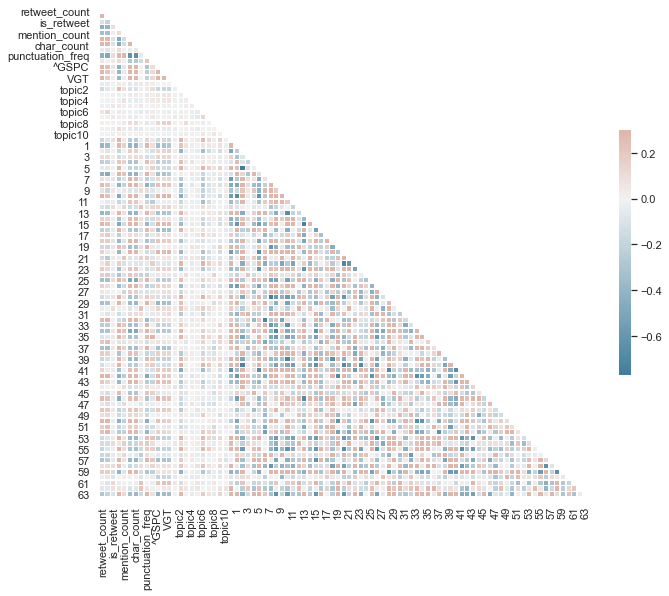

In [35]:
sns.set_theme(style="white")

# Compute the correlation matrix
corr = set3_df_grouped.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot = False)

plt.savefig("../plots/feature_set_3/correlation_plot.png", dpi=300, bbox_inches='tight')
plt.show()

#### Train test split

In [31]:
# target variables
set3_y_GSPC = set3_df_grouped['^GSPC']
set3_y_IXIC = set3_df_grouped['^IXIC']
set3_y_VGT = set3_df_grouped['VGT']

# features
set3_X = set3_df_grouped.drop(columns=['^GSPC', '^IXIC', 'VGT'], errors='ignore')
set3_X.shape

(1186, 84)

In [32]:
# GSPC
set3_X_train_GSPC, set3_X_test_GSPC, set3_y_train_GSPC, set3_y_test_GSPC = train_test_split(set3_X, set3_y_GSPC, 
                                                                                            test_size=1-TRAIN_RATIO, 
                                                                                            random_state=RANDOM_STATE)

# IXIC
set3_X_train_IXIC, set3_X_test_IXIC, set3_y_train_IXIC, set3_y_test_IXIC = train_test_split(set3_X, set3_y_IXIC, 
                                                                                            test_size=1-TRAIN_RATIO, 
                                                                                            random_state=RANDOM_STATE)

# VGT
set3_X_train_VGT, set3_X_test_VGT, set3_y_train_VGT, set3_y_test_VGT = train_test_split(set3_X, set3_y_VGT, 
                                                                                        test_size=1-TRAIN_RATIO, 
                                                                                        random_state=RANDOM_STATE)

# Modelling - XGBoost 
XGBoost is chosen to be the classification model for a few reasons:
* XGBoost is an ensemble method which helps improve machine learning results by combining and improving on the results from multiple single models.
* As compared to gradient boosting algorithms, XGBoost uses a more regularized model formalization to control over-fitting, which gives it better performance.
* XGBoost is built with the engineering goal to push the limit of computation resources for boosted tree algorithms. It utilises computational power more efficiently for faster, and production-ready training and testing, which is a good choice given the limited computation resources.

## Prepare models and define functions

### Initialise a dictionary to store the loss of various models

In [33]:
LOSS_DICTIONARY = {}

### Define baseline parameters

In [34]:
PARAMS = {'objective':'reg:linear',
          'learning_rate':0.05,
          'n_estimators':200,
          'early_stopping_rounds':10,
          'max_depth':10,
          'min_child_weight':5,
          'gamma':0.1,
          'subsample':0.7,
          'colsample_bytree':0.7,
          'n_jobs':4,
          'random_state':1,
          'seed':1
         }

### Define error metrics

Write a custom function to calculate MAPE, mean average percentage error. MAPE expresses expresses accuracy as a percentage of the error. Because the MAPE is a percentage, it can be easier to understand than the other accuracy measure statistics e.g. RMSE. Refer to the picture below for a guide on the interpretation of MAPE values

<img src="https://www.researchgate.net/profile/Albert_Sese/publication/257812432/figure/tbl1/AS:601657310203931@1520457689632/nterpretation-of-typical-MAPE-values.png" width=300 align="left"/>

In [35]:
# define custom functions to calculate MAPE

def percentage_error(actual, predicted):
    res = np.empty(actual.shape)
    for j in range(actual.shape[0]):
        if actual[j] != 0:
            res[j] = (actual[j] - predicted[j]) / actual[j]
        else:
            res[j] = predicted[j] / np.mean(actual)
    return res

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs(percentage_error(np.asarray(y_true), np.asarray(y_pred)))) * 100

### Define XGBoost functions

In [36]:
# train an XGBoost model on each target variable, output the final RMSE and MAPE scores

def train_models(X_train_GSPC, y_train_GSPC, X_test_GSPC, y_test_GSPC,
                 X_train_IXIC, y_train_IXIC, X_test_IXIC, y_test_IXIC,
                 X_train_VGT, y_train_VGT, X_test_VGT, y_test_VGT,
                 set_num, params=PARAMS):
    
    # obtain feature names
    columns = X_train_GSPC.columns.tolist()
    
    # initialise xgboost objects
    xgb_GSPC = xgboost.XGBModel(**params)
    xgb_IXIC = xgboost.XGBModel(**params)
    xgb_VGT = xgboost.XGBModel(**params)
    
    # train and evaluate the models
    print("##### Training GSPC #####")
    xgb_GSPC.fit(X_train_GSPC.values, y_train_GSPC,
                 eval_set=[(X_train_GSPC.values, y_train_GSPC), (X_test_GSPC.values, y_test_GSPC)],
                 eval_metric='rmse',
                 verbose=50
                )    
    print()
    print("##### Training IXIC #####")
    xgb_IXIC.fit(X_train_IXIC.values, y_train_IXIC,
                 eval_set=[(X_train_IXIC.values, y_train_IXIC), (X_test_IXIC.values, y_test_IXIC)],
                 eval_metric='rmse',
                 verbose=50
                )    
    print()
    print("##### Training VGT #####")
    xgb_VGT.fit(X_train_VGT.values, y_train_VGT,
                eval_set=[(X_train_VGT.values, y_train_VGT), (X_test_VGT.values, y_test_VGT)],
                eval_metric='rmse',
                verbose=50
               )
    print()
    
    # calculate the final RMSE and MAPE for each model
    GSPC_RMSE = sqrt(mean_squared_error(xgb_GSPC.predict(X_test_GSPC.values), y_test_GSPC))
    GSPC_MAPE = mean_absolute_percentage_error(y_test_GSPC, xgb_GSPC.predict(X_test_GSPC.values))
    IXIC_RMSE = sqrt(mean_squared_error(xgb_IXIC.predict(X_test_IXIC.values), y_test_IXIC))
    IXIC_MAPE = mean_absolute_percentage_error(y_test_IXIC, xgb_IXIC.predict(X_test_IXIC.values))
    VGT_RMSE = sqrt(mean_squared_error(xgb_VGT.predict(X_test_VGT.values), y_test_VGT))
    VGT_MAPE = mean_absolute_percentage_error(y_test_VGT, xgb_VGT.predict(X_test_VGT.values))
    print("##### Final Evaluation #####")
    print("- GSPC has an RMSE of {}, an MAPE of {}".format(GSPC_RMSE, GSPC_MAPE))
    print("- IXIC has an RMSE of {}, an MAPE of {}".format(IXIC_RMSE, IXIC_MAPE))
    print("- VGT has an RMSE of {}, an MAPE of {}".format(VGT_RMSE, VGT_MAPE))
    
    # append feature names to the models
    xgb_GSPC.get_booster().feature_names = columns
    xgb_IXIC.get_booster().feature_names = columns
    xgb_VGT.get_booster().feature_names = columns
    
    # store the loss in the dictionary
    loss_dict = {'GSPC_RMSE':GSPC_RMSE, 'GSPC_MAPE':GSPC_MAPE, 
                 'IXIC_RMSE':IXIC_RMSE, 'IXIC_MAPE':IXIC_MAPE, 
                 'VGT_RMSE':VGT_RMSE, 'VGT_MAPE':VGT_MAPE
                }
    LOSS_DICTIONARY[set_num] = loss_dict
    
#     # retrieve evaluation results
#     evals_result_GSPC = xgb_GSPC.evals_result()
#     evals_result_IXIC = xgb_IXIC.evals_result()
#     evals_result_VGT = xgb_VGT.evals_result()
    
    # return the trained models and the evaluation results
    return xgb_GSPC, xgb_IXIC, xgb_VGT

In [37]:
# plot feature importances graphs based on XGBoost's inbuilt feature importance algorithm

def plot_feature_importances(xgb_GSPC, xgb_IXIC, xgb_VGT, set_num, figsize=(15,4)):

    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=figsize)
    
    plot_importance(xgb_GSPC.get_booster(), title="GSPC Feature importance", ax=axes[0])
    plot_importance(xgb_IXIC.get_booster(), title="IXIC Feature importance", ax=axes[1])
    plot_importance(xgb_VGT.get_booster(), title="VGT Feature importance", ax=axes[2])
    
    fig.tight_layout()
    plt.savefig("../plots/"+set_num+"/XGBoost_feature_importance.png", dpi=300)
    fig.show()

### Define SHAP functions
SHAP (SHapley Additive exPlanations) is a game theoretic approach to explain the output of any machine learning model. It connects optimal credit allocation with local explanations using the classic Shapley values from game theory and their related extensions (see <a href="https://proceedings.neurips.cc/paper/2017/hash/8a20a8621978632d76c43dfd28b67767-Abstract.html">papers </a>for details)
<br>
<br>
In essence, SHAP values represent a feature's responsibility for a change in the model output. The larger the magnitude of a feature's SHAP value, the more influence it has on the model output. Negative SHAP values push the prediction lower and are shown in blue, whereas positive SHAP values push the prediction higher and are shown in red.

In [38]:
def generate_shap_objects(xgb_GSPC, xgb_IXIC, xgb_VGT,
                          X_train_GSPC, K=100
                         ):
    xgb_GSPC.get_booster().feature_names=None
    xgb_IXIC.get_booster().feature_names=None
    xgb_VGT.get_booster().feature_names=None
    
    samples = shap.sample(X_train_GSPC, K) # sample K records
    
    explainer_GSPC = shap.KernelExplainer(xgb_GSPC.predict, samples)
    shap_values_GSPC = explainer_GSPC.shap_values(samples)
    
    explainer_IXIC = shap.KernelExplainer(xgb_IXIC.predict, samples)
    shap_values_IXIC = explainer_IXIC.shap_values(samples)
    
    explainer_VGT = shap.KernelExplainer(xgb_VGT.predict, samples)
    shap_values_VGT = explainer_VGT.shap_values(samples)
    
    return explainer_GSPC, shap_values_GSPC, explainer_IXIC, shap_values_IXIC, explainer_VGT, shap_values_VGT, samples

In [39]:
def generate_shap_summary_plots(shap_values_GSPC, shap_values_IXIC, shap_values_VGT, samples, set_num, figsize=(18,5)):
    """
    This plot sorts features by the sum of SHAP value magnitudes over all samples, 
    and uses SHAP values to show the distribution of the impacts each feature has on the model output. 
    The color represents the feature value (red high, blue low). 
    """
    plt.figure(figsize=figsize)

    plt.subplot(1,3,1)
    plt.gca().set_title('GSPC')
    shap.summary_plot(shap_values_GSPC, samples, plot_size=None, show=False)
    
    plt.subplot(1,3,2)
    plt.gca().set_title('IXIC')
    shap.summary_plot(shap_values_IXIC, samples, plot_size=None, show=False)

    plt.subplot(1,3,3)
    plt.gca().set_title('VGT')
    shap.summary_plot(shap_values_VGT, samples, plot_size=None, show=False)
    
    plt.tight_layout()
    plt.savefig("../plots/"+set_num+"/SHAP_summary_plot.png", dpi=300)
    plt.show()

In [40]:
def generate_shap_bar_plots(shap_values_GSPC, shap_values_IXIC, shap_values_VGT, samples, set_num, figsize=(18,5)):
    """
    This plot takes the mean absolute value of the SHAP values for each feature to get a standard bar plot
    """
    plt.figure(figsize=figsize)

    plt.subplot(1,3,1)
    plt.gca().set_title('GSPC')
    shap.summary_plot(shap_values_GSPC, samples, plot_type="bar", plot_size=None, show=False)
    
    plt.subplot(1,3,2)
    plt.gca().set_title('IXIC')
    shap.summary_plot(shap_values_GSPC, samples, plot_type="bar", plot_size=None, show=False)

    plt.subplot(1,3,3)
    plt.gca().set_title('VGT')
    shap.summary_plot(shap_values_GSPC, samples, plot_type="bar", plot_size=None, show=False)
    
    plt.tight_layout()
    plt.savefig("../plots/"+set_num+"/SHAP_bar_plot.png", dpi=300)
    plt.show()

## Build models

### Modelling on feature set 1

#### Train and evaluate on feature set 1

In [41]:
set1_xgb_GSPC, set1_xgb_IXIC, set1_xgb_VGT = train_models(set1_X_train_GSPC, set1_y_train_GSPC, set1_X_test_GSPC, set1_y_test_GSPC,
                                                          set1_X_train_IXIC, set1_y_train_IXIC, set1_X_test_IXIC, set1_y_test_IXIC,
                                                          set1_X_train_VGT, set1_y_train_VGT, set1_X_test_VGT, set1_y_test_VGT,
                                                          'feature_set_1', params=PARAMS)

##### Training GSPC #####
[0]	validation_0-rmse:2530.02	validation_1-rmse:2550.5
[50]	validation_0-rmse:270.72	validation_1-rmse:323.249
[100]	validation_0-rmse:96.0145	validation_1-rmse:226.614
[150]	validation_0-rmse:58.3227	validation_1-rmse:225.872
[199]	validation_0-rmse:38.2907	validation_1-rmse:226.896

##### Training IXIC #####
[0]	validation_0-rmse:6946.57	validation_1-rmse:6963.22
[50]	validation_0-rmse:893.481	validation_1-rmse:1196.58
[100]	validation_0-rmse:366.738	validation_1-rmse:1010.86
[150]	validation_0-rmse:228.062	validation_1-rmse:1014.1
[199]	validation_0-rmse:151.334	validation_1-rmse:1017.47

##### Training VGT #####
[0]	validation_0-rmse:173.698	validation_1-rmse:174.49
[50]	validation_0-rmse:25.8896	validation_1-rmse:37.9563
[100]	validation_0-rmse:11.5942	validation_1-rmse:33.8881
[150]	validation_0-rmse:7.1617	validation_1-rmse:33.9041
[199]	validation_0-rmse:4.71731	validation_1-rmse:34.0527

##### Final Evaluation #####
- GSPC has an RMSE of 226.895757301

#### generate SHAP objects for feature set 1

In [239]:
set1_explainer_GSPC, set1_shap_values_GSPC, set1_explainer_IXIC, set1_shap_values_IXIC, set1_explainer_VGT, set1_shap_values_VGT, set1_samples = generate_shap_objects(
    set1_xgb_GSPC, set1_xgb_IXIC, set1_xgb_VGT, set1_X_train_GSPC)

In [344]:
# with open('../model/SHAP/set1.pkl', 'wb') as f:
#     pickle.dump([set1_explainer_GSPC, set1_shap_values_GSPC, 
#                  set1_explainer_IXIC, set1_shap_values_IXIC, 
#                  set1_explainer_VGT, set1_shap_values_VGT, 
#                  set1_samples], f)

In [42]:
with open('../model/SHAP/set1.pkl', 'rb') as f:
    set1_explainer_GSPC, set1_shap_values_GSPC, set1_explainer_IXIC, set1_shap_values_IXIC,set1_explainer_VGT, set1_shap_values_VGT, set1_samples = pickle.load(f)

#### Plot feature importances

Feature importances via built-in xgboost function

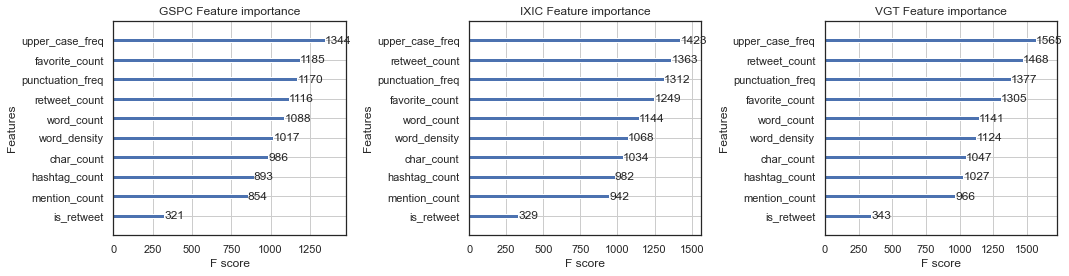

In [43]:
plot_feature_importances(set1_xgb_GSPC, set1_xgb_IXIC, set1_xgb_VGT, 'feature_set_1', (15,4))

Feature importances via SHAP

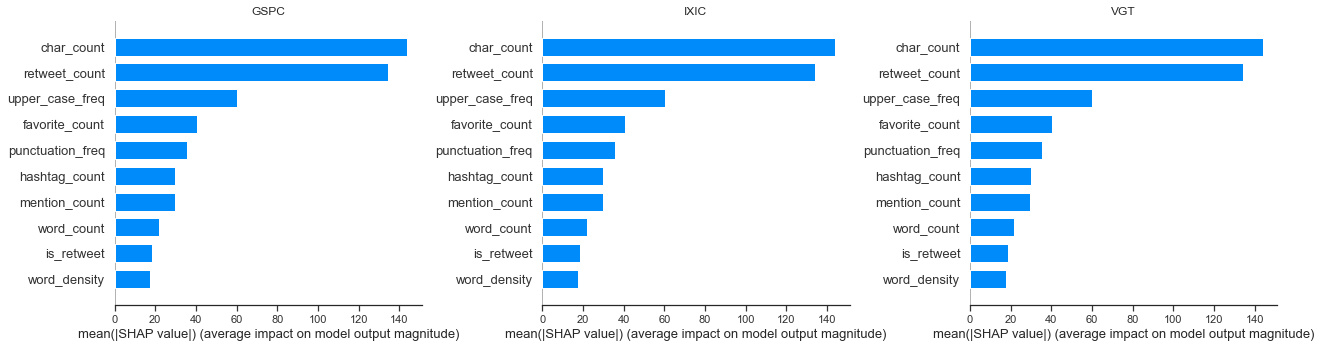

In [340]:
generate_shap_bar_plots(set1_shap_values_GSPC, set1_shap_values_IXIC, set1_shap_values_VGT, 
                        set1_samples, 'feature_set_1', (18,5))

#### Explain feature influence

SHAP summary plots

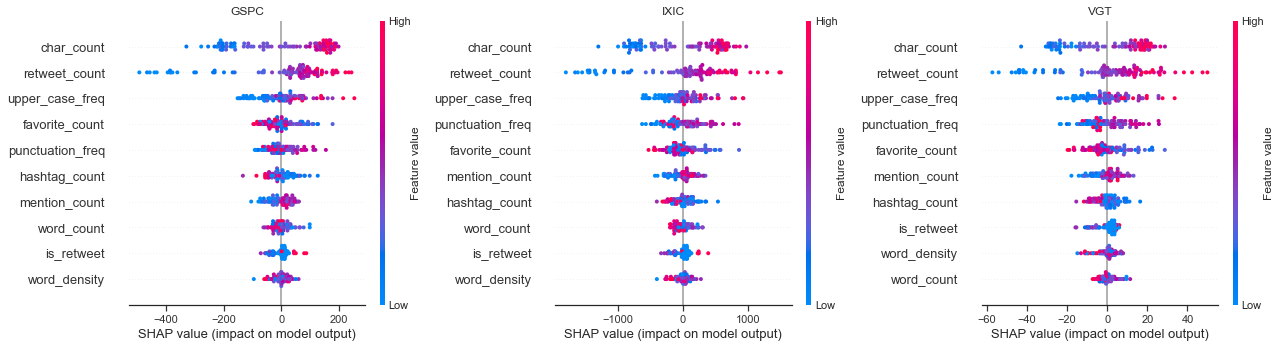

In [341]:
generate_shap_summary_plots(set1_shap_values_GSPC, set1_shap_values_IXIC, set1_shap_values_VGT, 
                            set1_samples, 'feature_set_1', (18,5))

SHAP force plots

In [53]:
# GSPC
shap.force_plot(set1_explainer_GSPC.expected_value, set1_shap_values_GSPC, set1_samples, show=True)

In [55]:
# IXIC
shap.force_plot(set1_explainer_IXIC.expected_value, set1_shap_values_IXIC, set1_samples, show=True)

In [56]:
# VGT
shap.force_plot(set1_explainer_VGT.expected_value, set1_shap_values_VGT, set1_samples, show=True)

### Modelling on feature set 2

#### Train and evaluate on feature set 2

In [44]:
set2_xgb_GSPC, set2_xgb_IXIC, set2_xgb_VGT = train_models(set2_X_train_GSPC, set2_y_train_GSPC, set2_X_test_GSPC, set2_y_test_GSPC,
                                                          set2_X_train_IXIC, set2_y_train_IXIC, set2_X_test_IXIC, set2_y_test_IXIC,
                                                          set2_X_train_VGT, set2_y_train_VGT, set2_X_test_VGT, set2_y_test_VGT,
                                                          'feature_set_2', params=PARAMS)

##### Training GSPC #####
[0]	validation_0-rmse:2530.02	validation_1-rmse:2550.5
[50]	validation_0-rmse:264.869	validation_1-rmse:318.625
[100]	validation_0-rmse:92.9709	validation_1-rmse:224.611
[150]	validation_0-rmse:55.9871	validation_1-rmse:222.427
[199]	validation_0-rmse:35.1074	validation_1-rmse:222.742

##### Training IXIC #####
[0]	validation_0-rmse:6946.26	validation_1-rmse:6960.84
[50]	validation_0-rmse:861.186	validation_1-rmse:1182.67
[100]	validation_0-rmse:362.967	validation_1-rmse:984.349
[150]	validation_0-rmse:233.238	validation_1-rmse:979.007
[199]	validation_0-rmse:153.992	validation_1-rmse:983.749

##### Training VGT #####
[0]	validation_0-rmse:173.716	validation_1-rmse:174.413
[50]	validation_0-rmse:24.74	validation_1-rmse:37.7571
[100]	validation_0-rmse:11.5101	validation_1-rmse:33.3491
[150]	validation_0-rmse:7.52238	validation_1-rmse:33.1729
[199]	validation_0-rmse:5.03207	validation_1-rmse:33.1188

##### Final Evaluation #####
- GSPC has an RMSE of 222.7421629

#### generate SHAP objects for feature set 2

In [319]:
set2_explainer_GSPC, set2_shap_values_GSPC, set2_explainer_IXIC, set2_shap_values_IXIC, set2_explainer_VGT, set2_shap_values_VGT, set2_samples = generate_shap_objects(
    set2_xgb_GSPC, set2_xgb_IXIC, set2_xgb_VGT, set2_X_train_GSPC)

In [346]:
# with open('../model/SHAP/set2.pkl', 'wb') as f:
#     pickle.dump([set2_explainer_GSPC, set2_shap_values_GSPC, 
#                  set2_explainer_IXIC, set2_shap_values_IXIC, 
#                  set2_explainer_VGT, set2_shap_values_VGT, 
#                  set2_samples], f)

In [45]:
with open('../model/SHAP/set2.pkl', 'rb') as f:
    set2_explainer_GSPC, set2_shap_values_GSPC, set2_explainer_IXIC, set2_shap_values_IXIC, set2_explainer_VGT, set2_shap_values_VGT, set2_samples = pickle.load(f)

#### Plot feature importances

Feature importances via built-in xgboost function

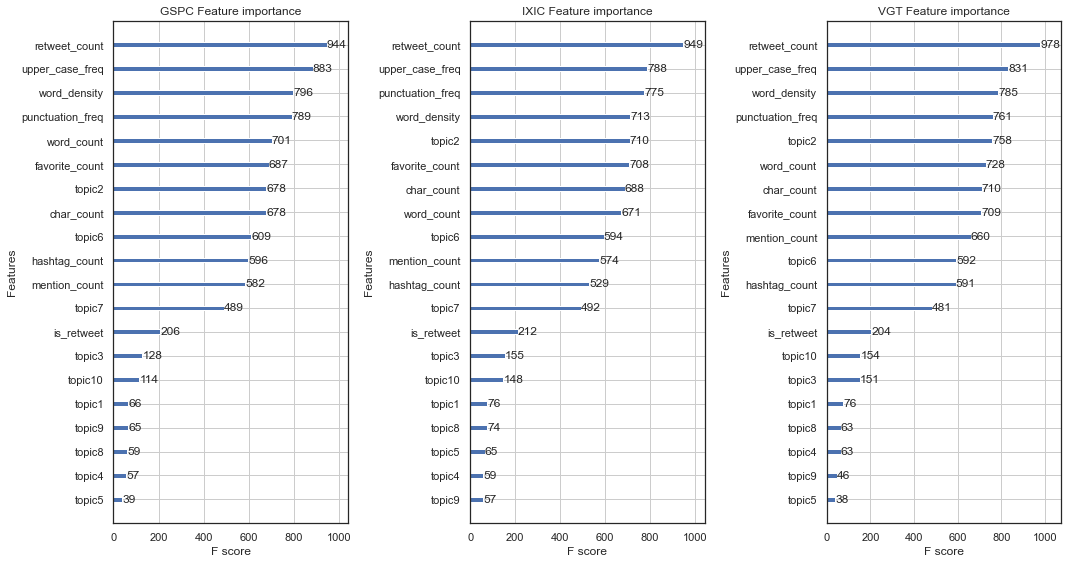

In [350]:
plot_feature_importances(set2_xgb_GSPC, set2_xgb_IXIC, set2_xgb_VGT, 'feature_set_2', (15,8))

Feature importances via SHAP

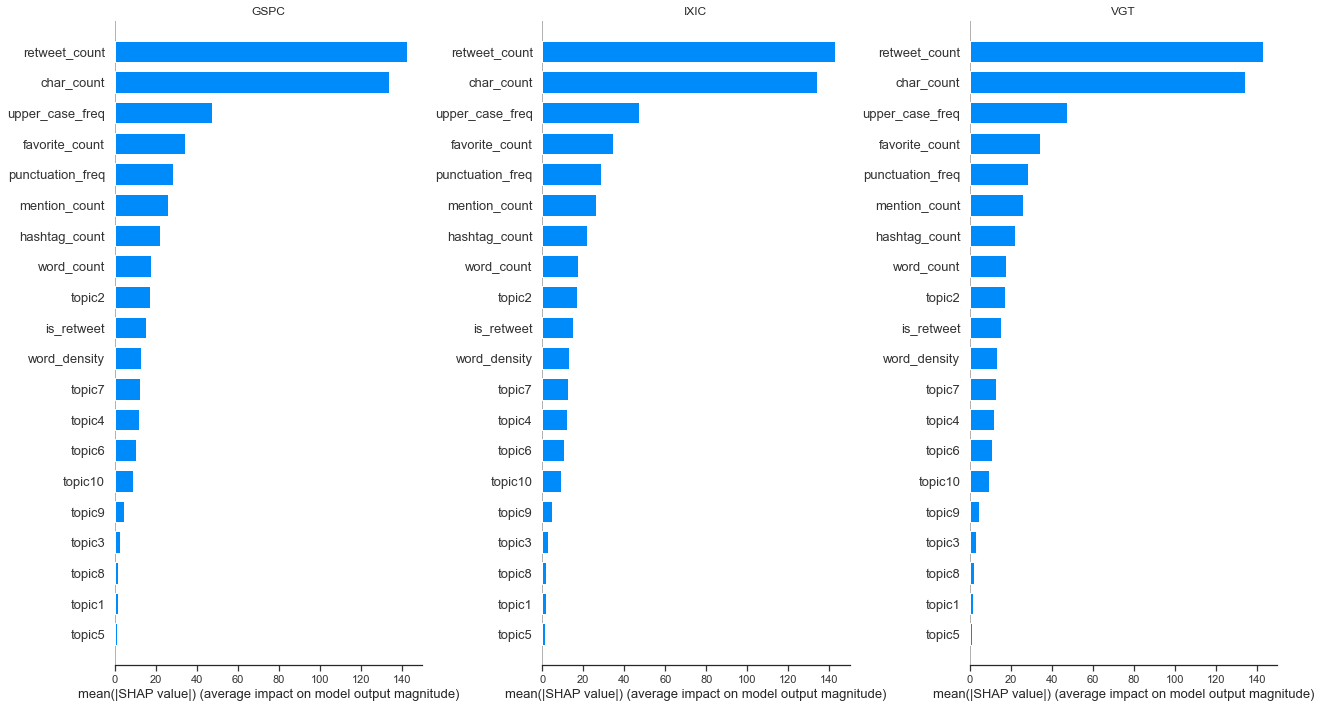

In [351]:
generate_shap_bar_plots(set2_shap_values_GSPC, set2_shap_values_IXIC, set2_shap_values_VGT, 
                        set2_samples, 'feature_set_2', (18,10))

#### Explain feature influence

SHAP summary plots

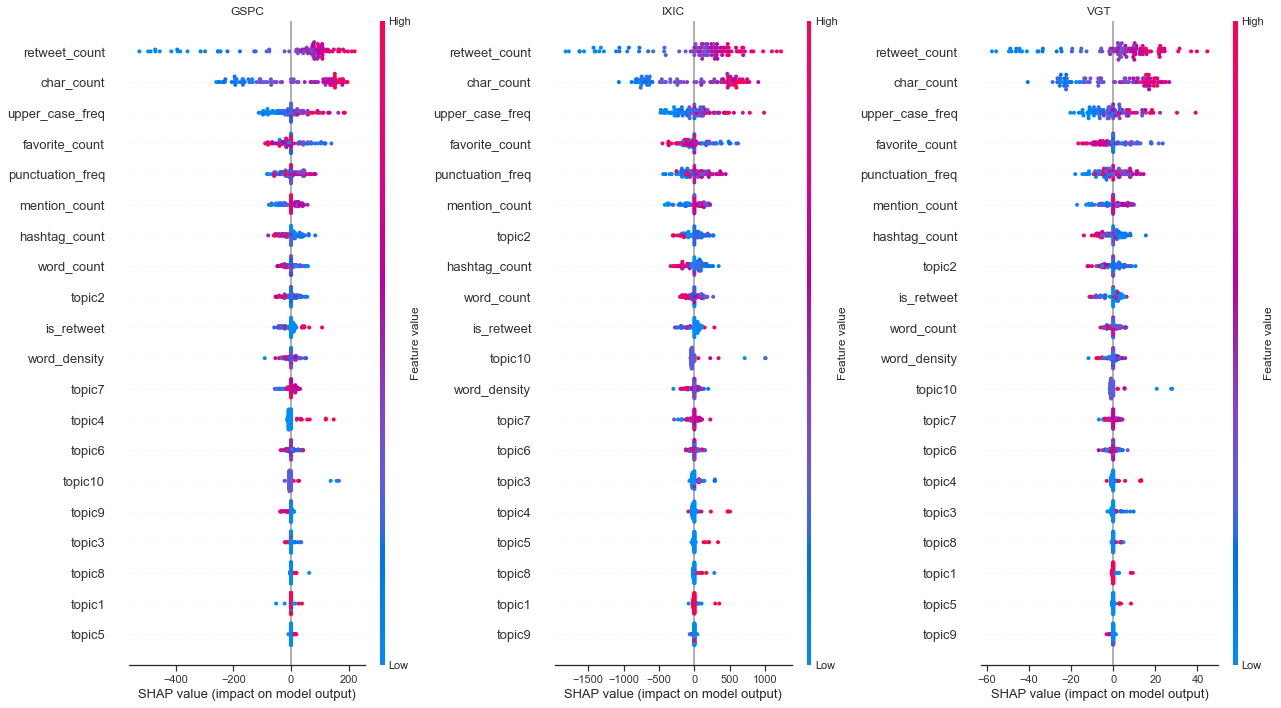

In [352]:
generate_shap_summary_plots(set2_shap_values_GSPC, set2_shap_values_IXIC, set2_shap_values_VGT, 
                            set2_samples, 'feature_set_2', (18,10))

SHAP force plots

In [59]:
# GSPC
shap.force_plot(set2_explainer_GSPC.expected_value, set2_shap_values_GSPC, set2_samples, show=True)

In [60]:
# IXIC
shap.force_plot(set2_explainer_IXIC.expected_value, set2_shap_values_IXIC, set2_samples, show=True)

In [61]:
# VGT
shap.force_plot(set2_explainer_VGT.expected_value, set2_shap_values_VGT, set2_samples, show=True)

### Modelling on feature set 3

#### Train and evaluate on feature set 3

In [46]:
set3_xgb_GSPC, set3_xgb_IXIC, set3_xgb_VGT = train_models(set3_X_train_GSPC, set3_y_train_GSPC, set3_X_test_GSPC, set3_y_test_GSPC,
                                                          set3_X_train_IXIC, set3_y_train_IXIC, set3_X_test_IXIC, set3_y_test_IXIC,
                                                          set3_X_train_VGT, set3_y_train_VGT, set3_X_test_VGT, set3_y_test_VGT,
                                                          'feature_set_3', params=PARAMS)

##### Training GSPC #####
[0]	validation_0-rmse:2530.02	validation_1-rmse:2550.5
[50]	validation_0-rmse:248.036	validation_1-rmse:311.578
[100]	validation_0-rmse:52.3012	validation_1-rmse:213.24
[150]	validation_0-rmse:22.6933	validation_1-rmse:209.421
[199]	validation_0-rmse:12.9041	validation_1-rmse:208.375

##### Training IXIC #####
[0]	validation_0-rmse:6946.26	validation_1-rmse:6960.84
[50]	validation_0-rmse:765.326	validation_1-rmse:1158.37
[100]	validation_0-rmse:189.52	validation_1-rmse:941.65
[150]	validation_0-rmse:92.5244	validation_1-rmse:927.362
[199]	validation_0-rmse:55.9902	validation_1-rmse:922.642

##### Training VGT #####
[0]	validation_0-rmse:173.7	validation_1-rmse:174.348
[50]	validation_0-rmse:20.6305	validation_1-rmse:36.0179
[100]	validation_0-rmse:5.48752	validation_1-rmse:31.0057
[150]	validation_0-rmse:2.57058	validation_1-rmse:30.5177
[199]	validation_0-rmse:1.61187	validation_1-rmse:30.4532

##### Final Evaluation #####
- GSPC has an RMSE of 208.3746172034

#### generate SHAP objects for feature set 3

In [ ]:
set3_explainer_GSPC, set3_shap_values_GSPC, set3_explainer_IXIC, set3_shap_values_IXIC, set3_explainer_VGT, set3_shap_values_VGT, set3_samples = generate_shap_objects(
    set3_xgb_GSPC, set3_xgb_IXIC, set3_xgb_VGT, set3_X_train_GSPC)

In [358]:
# with open('../model/SHAP/set3.pkl', 'wb') as f:
#     pickle.dump([set3_explainer_GSPC, set3_shap_values_GSPC, 
#                  set3_explainer_IXIC, set3_shap_values_IXIC, 
#                  set3_explainer_VGT, set3_shap_values_VGT, 
#                  set3_samples], f)

In [48]:
with open('../model/SHAP/set3.pkl', 'rb') as f:
    set3_explainer_GSPC, set3_shap_values_GSPC, set3_explainer_IXIC, set3_shap_values_IXIC, set3_explainer_VGT, set3_shap_values_VGT, set3_samples = pickle.load(f)

#### Plot feature importances

Feature importances via built-in xgboost function

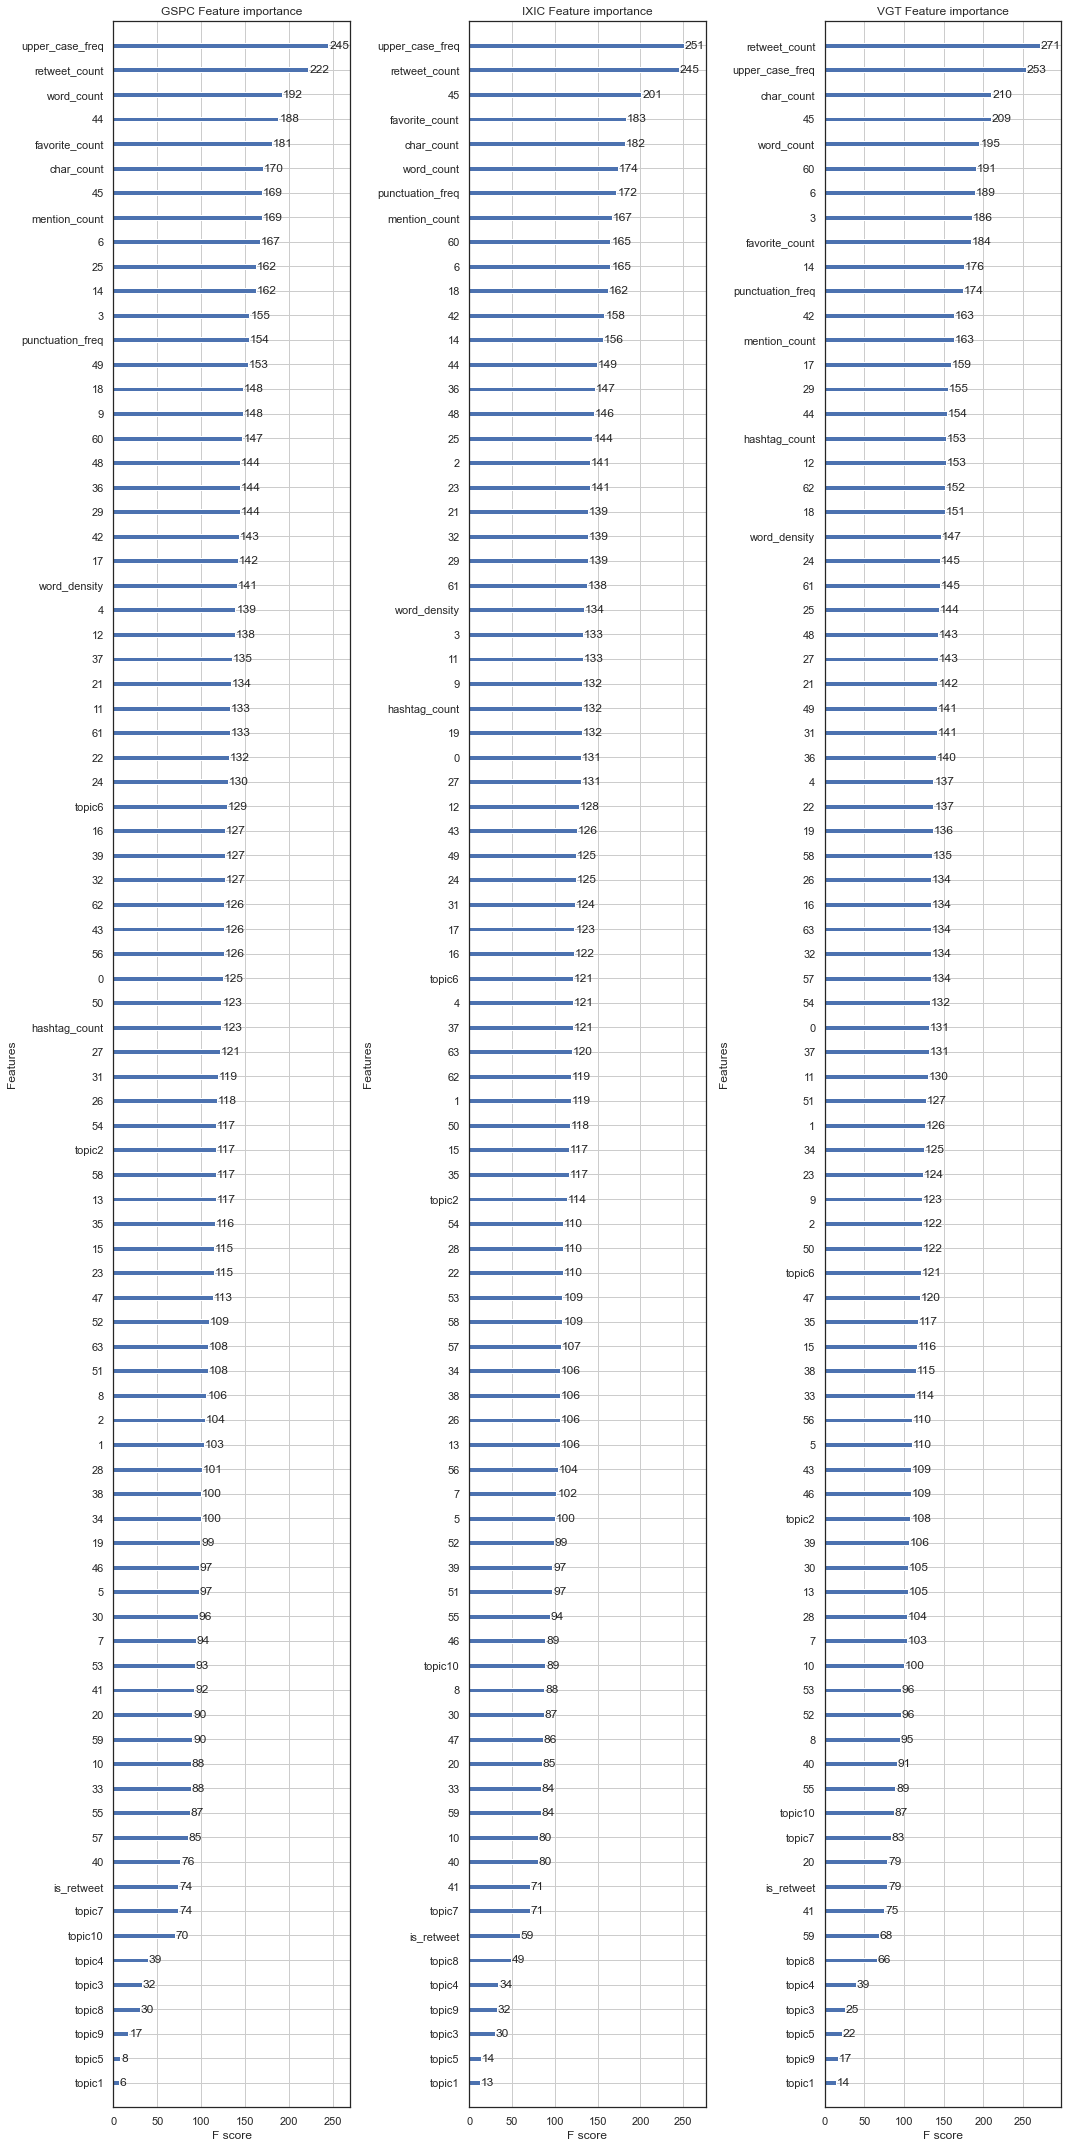

In [362]:
plot_feature_importances(set3_xgb_GSPC, set3_xgb_IXIC, set3_xgb_VGT, 'feature_set_3', (15,30))

Feature importances via SHAP

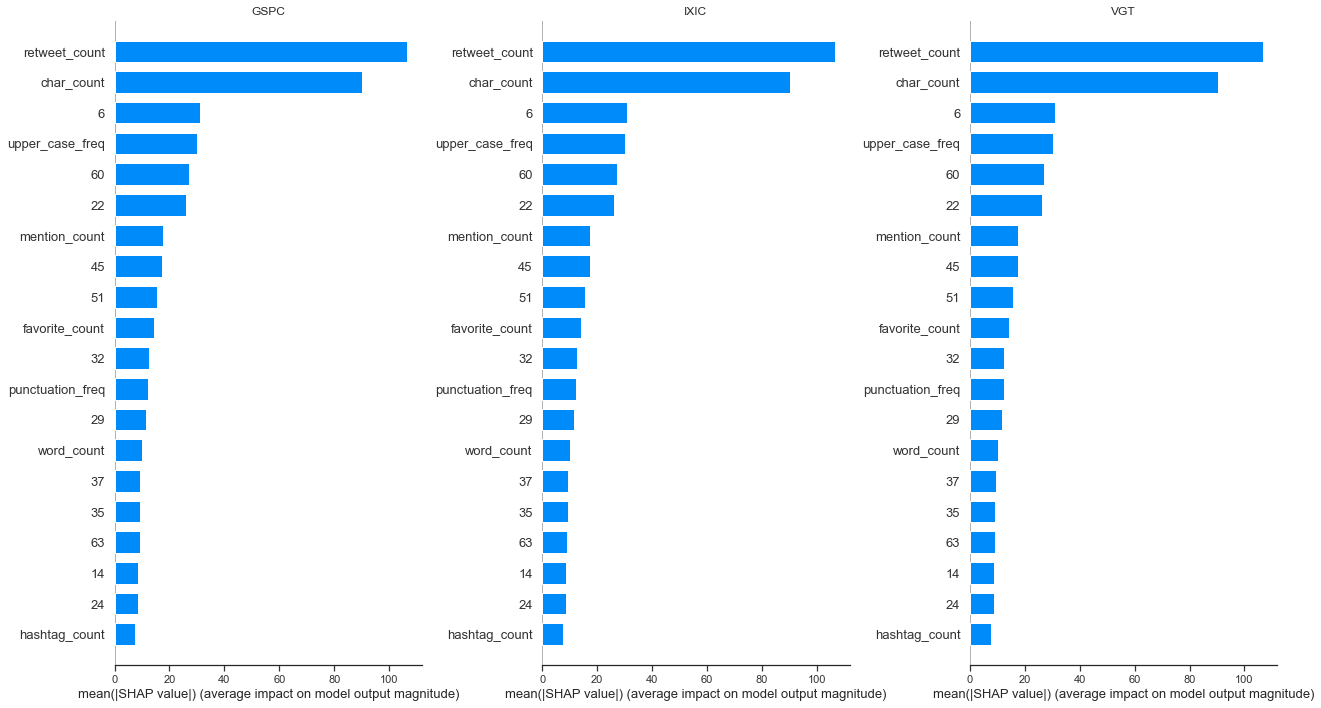

In [365]:
generate_shap_bar_plots(set3_shap_values_GSPC, set3_shap_values_IXIC, set3_shap_values_VGT, 
                        set3_samples, 'feature_set_3', (18,10))

#### Explain feature influence

SHAP summary plots

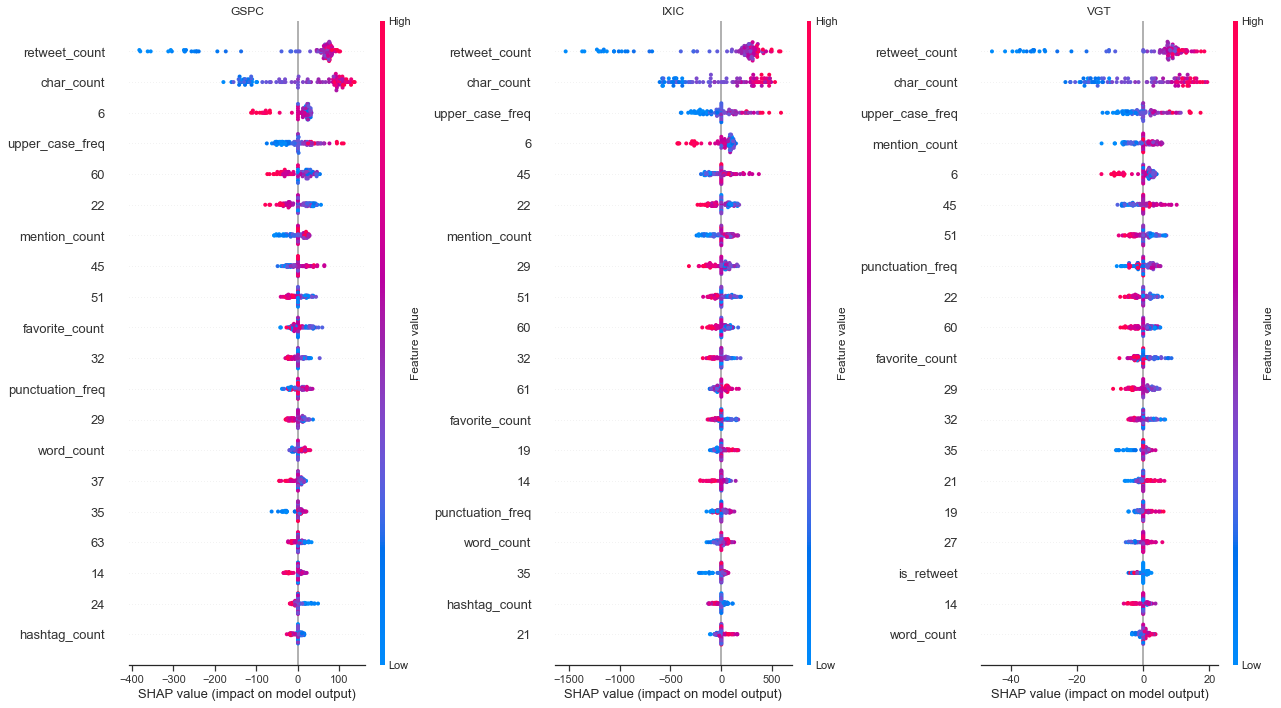

In [366]:
generate_shap_summary_plots(set3_shap_values_GSPC, set3_shap_values_IXIC, set3_shap_values_VGT, 
                            set3_samples, 'feature_set_3', (18,10))

SHAP force plots

In [64]:
# GSPC
shap.force_plot(set3_explainer_GSPC.expected_value, set3_shap_values_GSPC, set3_samples, show=True)

In [65]:
# IXIC
shap.force_plot(set3_explainer_IXIC.expected_value, set3_shap_values_IXIC, set3_samples, show=True)

In [66]:
# VGT
shap.force_plot(set3_explainer_VGT.expected_value, set3_shap_values_VGT, set3_samples, show=True)

#### SHAP values of a single observation

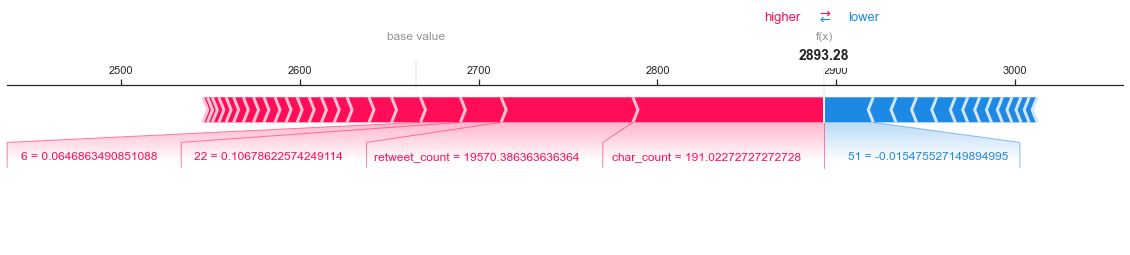

In [59]:
# GSPC
shap.force_plot(set3_explainer_GSPC.expected_value, set3_shap_values_GSPC[0,:], 
                set3_samples.iloc[0,:], show=False, matplotlib=True)
plt.savefig("../plots/feature_set_3/SHAP_individual_obs.png", dpi=300, bbox_inches='tight')
plt.show()

## Evaluate performance

In [49]:
loss_df = pd.DataFrame.from_dict(LOSS_DICTIONARY, orient='index')
loss_df

GSPC_RMSE  GSPC_MAPE    IXIC_RMSE  IXIC_MAPE   VGT_RMSE  \
feature_set_1  226.895757   5.921106  1017.471473   9.296118  34.052712   
feature_set_2  222.742163   5.783481   983.748501   9.044359  33.118841   
feature_set_3  208.374617   5.701590   922.641796   8.659153  30.453157   

                VGT_MAPE  
feature_set_1  12.919860  
feature_set_2  12.706674  
feature_set_3  12.226851

In [386]:
# with open('../model/XGBoost/loss_df.pickle', 'wb') as f:
#     pickle.dump(loss_df, f)

In [50]:
with open('../model/XGBoost/loss_df.pickle', 'rb') as f:
    loss_df = pickle.load(f)

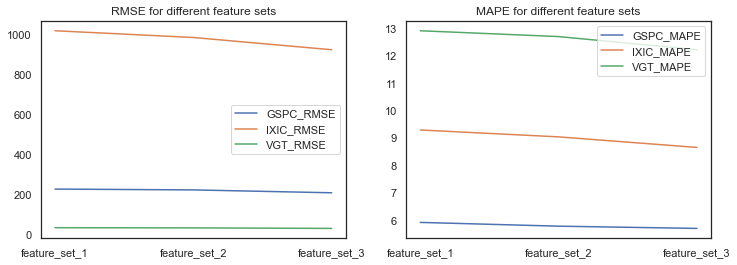

In [51]:
sns.set_style("white")
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,4))
loss_df.plot(y=['GSPC_RMSE', 'IXIC_RMSE', 'VGT_RMSE'], kind="line", ax=axes[0], title="RMSE for different feature sets")
loss_df.plot(y=['GSPC_MAPE', 'IXIC_MAPE', 'VGT_MAPE'], kind="line", ax=axes[1], title="MAPE for different feature sets")
plt.savefig("../plots/RMSE_MAPE_training.png", dpi=300)
plt.show()

It seems that feature set 3 performs the best out of the three different feature sets, as it has the lowest RMSE and MAPE when predicting GSPC, IXIC and VGT. We will use feature set 3 as the chosen feature set and use the XGBoost model fitted on this feature set to predict the stock prices in October 2020.

# Final testing
Perform a final test on Trump's tweets from 1 Oct to 31 Oct.

## Prepare feature set for testing

In [62]:
test = pd.read_csv('../data/test_data_tweets&sentiment&topic&absoluteprices.csv', index_col=0).drop(columns=['index'])
test.head()

source                                               text  \
0  Twitter for iPhone  I won the debate big based on compilation of p...   
1  Twitter for iPhone  Why would I allow the Debate Commission to cha...   
2  Twitter for iPhone           THANK YOU! #MAGA https://t.co/nGfbRmfmG7   
3  Twitter for iPhone  Exclusive Excerpt--Lewandowski &amp; Bossie: ‘...   
4  Twitter for iPhone  RT @GreggJarrett: Corrupt Comey conveniently c...   

                                        cleaned_text           created_at  \
0         debate big base compilation poll etc thank  2020-10-01 11:14:28   
1  would allow debate commission change rule seco...  2020-10-01 14:15:26   
2                                         thank maga  2020-10-01 15:09:17   
3  exclusive excerpt lewandowski amp bossie trump...  2020-10-01 17:12:22   
4  corrupt comey conveniently claim no memory par...  2020-10-01 17:14:12   

   retweet_count  favorite_count  is_retweet               id_str    hashtag  \
0          44961          337926       False  1311685923097260034         []   
1          41516          247053       False  1311731462589292544         []   
2          18014           63744       False  1311745016780460033  ['#MAGA']   
3           6407           23646       False  1311775992847818754         []   
4           4755               0        True  1311776453717942272         []   

              mention  ...  pos_sentiment  compound_sentiment  created_date  \
0                  []  ...          0.318              0.4199    2020-10-01   
1                  []  ...          0.281              0.5106    2020-10-01   
2                  []  ...          0.583              0.4199    2020-10-01   
3  ['@BreitbartNews']  ...          0.362              0.8439    2020-10-01   
4                  []  ...          0.000             -0.2960    2020-10-01   

   created_time  passed_closing  market_date        ^GSPC         ^IXIC  \
0      11:14:28               0   2020-10-01  3380.800049  11326.509766   
1      14:15:26               0   2020-10-01  3380.800049  11326.509766   
2      15:09:17               0   2020-10-01  3380.800049  11326.509766   
3      17:12:22               1   2020-10-02  3348.419922  11075.019531   
4      17:14:12               1   2020-10-02  3348.419922  11075.019531   

          VGT  topic  
0  315.329987      9  
1  315.329987      6  
2  315.329987      9  
3  308.070007      1  
4  308.070007      5  

[5 rows x 29 columns]

### Drop features

In [63]:
# drop review_no, product_id and review_date
test = test.drop(columns=['source', 'text', 'created_at', 'id_str', 'hashtag', 'mention', 
                          'neg_sentiment', 'neu_sentiment', 'pos_sentiment', 'created_date',
                          'created_time', 'passed_closing'
                         ], errors='ignore')

In [64]:
test.columns

Index(['cleaned_text', 'retweet_count', 'favorite_count', 'is_retweet',
       'hashtag_count', 'mention_count', 'word_count', 'char_count',
       'word_density', 'punctuation_freq', 'upper_case_freq',
       'compound_sentiment', 'market_date', '^GSPC', '^IXIC', 'VGT', 'topic'],
      dtype='object')

### Type casting

In [65]:
# change is_tweet from boolean to binary
test['is_retweet'] = test['is_retweet'].replace({True:1, False:0})

## Prepare different feature sets for testing
We prepare three different feature sets from the test data just like how it has been done on the train data.

### Feature set 1: Meta text features
In this feature set, only meta text features e.g. word count, punctuation frequency, are used to predict the stock prices

#### Drop features

In [66]:
test1_df = test.drop(columns=['cleaned_text', 'cleaned_text_w2v', 'topic', 'compound_sentiment'], errors='ignore')

In [67]:
test1_df.columns

Index(['retweet_count', 'favorite_count', 'is_retweet', 'hashtag_count',
       'mention_count', 'word_count', 'char_count', 'word_density',
       'punctuation_freq', 'upper_case_freq', 'market_date', '^GSPC', '^IXIC',
       'VGT'],
      dtype='object')

#### Group by day

In [68]:
test1_df_grouped = test1_df.groupby('market_date').mean()
test1_df_grouped.head()

retweet_count  favorite_count  is_retweet  hashtag_count  \
market_date                                                             
2020-10-01    34830.333333   216241.000000    0.000000       0.333333   
2020-10-02    23461.477273    58863.386364    0.840909       0.022727   
2020-10-05    52996.437500   296731.781250    0.125000       0.093750   
2020-10-06    32445.666667   165082.857143    0.000000       0.000000   
2020-10-07    23030.730769    49591.557692    0.548077       0.134615   

             mention_count  word_count  char_count  word_density  \
market_date                                                        
2020-10-01        0.000000   14.666667   69.333333      4.405556   
2020-10-02        0.295455   19.568182  106.022727      5.392871   
2020-10-05        0.156250   20.562500  102.687500      4.813073   
2020-10-06        0.238095   38.761905  198.333333      4.953241   
2020-10-07        0.192308   23.250000  122.538462      5.212676   

             punctuation_freq  upper_case_freq        ^GSPC         ^IXIC  \
market_date                                                                 
2020-10-01           0.191667         0.250000  3380.800049  11326.509766   
2020-10-02           0.216006         0.080107  3348.419922  11075.019531   
2020-10-05           0.272551         0.376988  3408.600098  11332.490234   
2020-10-06           0.190124         0.131421  3360.969971  11154.599609   
2020-10-07           0.210228         0.122730  3419.439941  11364.599609   

                    VGT  
market_date              
2020-10-01   315.329987  
2020-10-02   308.070007  
2020-10-05   315.070007  
2020-10-06   310.730011  
2020-10-07   316.609985

#### Features target split

In [69]:
# target variables
test1_y_GSPC = test1_df_grouped['^GSPC']
test1_y_IXIC = test1_df_grouped['^IXIC']
test1_y_VGT = test1_df_grouped['VGT']

# features
test1_X = test1_df_grouped.drop(columns=['^GSPC', '^IXIC', 'VGT', 'market_date'], errors='ignore')
test1_X.shape

(23, 10)

### Feature set 2: Meta text features + topic-based sentiment scores
In this feature set, we supplement the the meta text features with topic-based sentiment scores. Topic of a tweet is obtained from running topic modelling at the preprocessing stage. Likewise, sentiment of a tweet is obtained via sentiment analysis using VADER.
<br>
There are in total 10 topics. For the topic that a tweet is in, its sentiment score will be attached to that topic. The sentiment scores for the remaining 9 topics are 0.

#### Get dummies for topic-based sentiment

In [70]:
dummies_test = pd.get_dummies(test['topic'])

In [71]:
topic_based_sentiment_test = pd.DataFrame()

In [72]:
for col in dummies_test.columns:
    topic_based_sentiment_test[col] = dummies_test[col]*test['compound_sentiment']

In [73]:
topic_based_sentiment_test.columns = ['topic1', 'topic2', 'topic3', 'topic4', 'topic5','topic6', 'topic7', 'topic8', 'topic9', 'topic10']

In [74]:
topic_based_sentiment_test.head()

topic1  topic2  topic3  topic4  topic5  topic6  topic7  topic8  topic9  \
0  0.0000     0.0     0.0     0.0   0.000  0.0000     0.0     0.0  0.4199   
1  0.0000     0.0     0.0     0.0   0.000  0.5106     0.0     0.0  0.0000   
2  0.0000     0.0     0.0     0.0   0.000  0.0000     0.0     0.0  0.4199   
3  0.8439     0.0     0.0     0.0   0.000  0.0000     0.0     0.0  0.0000   
4 -0.0000    -0.0    -0.0    -0.0  -0.296 -0.0000    -0.0    -0.0 -0.0000   

   topic10  
0      0.0  
1      0.0  
2      0.0  
3      0.0  
4     -0.0

#### Concatenate meta text features to form the second features set

In [75]:
test2_df = pd.concat([test1_df, topic_based_sentiment_test], axis=1)
test2_df.head()

retweet_count  favorite_count  is_retweet  hashtag_count  mention_count  \
0          44961          337926           0              0              0   
1          41516          247053           0              0              0   
2          18014           63744           0              1              0   
3           6407           23646           0              0              1   
4           4755               0           1              0              0   

   word_count  char_count  word_density  punctuation_freq  upper_case_freq  \
0          15          68      4.533333          0.133333         0.066667   
1          24         122      5.083333          0.041667         0.083333   
2           5          18      3.600000          0.400000         0.600000   
3          30         160      5.333333          0.366667         0.000000   
4          17         109      6.411765          0.176471         0.058824   

   ...  topic1  topic2  topic3  topic4  topic5  topic6  topic7  topic8  \
0  ...  0.0000     0.0     0.0     0.0   0.000  0.0000     0.0     0.0   
1  ...  0.0000     0.0     0.0     0.0   0.000  0.5106     0.0     0.0   
2  ...  0.0000     0.0     0.0     0.0   0.000  0.0000     0.0     0.0   
3  ...  0.8439     0.0     0.0     0.0   0.000  0.0000     0.0     0.0   
4  ... -0.0000    -0.0    -0.0    -0.0  -0.296 -0.0000    -0.0    -0.0   

   topic9  topic10  
0  0.4199      0.0  
1  0.0000      0.0  
2  0.4199      0.0  
3  0.0000      0.0  
4 -0.0000     -0.0  

[5 rows x 24 columns]

#### Group by day

In [76]:
test2_df_grouped = test2_df.groupby('market_date').mean()
test2_df_grouped.head()

retweet_count  favorite_count  is_retweet  hashtag_count  \
market_date                                                             
2020-10-01    34830.333333   216241.000000    0.000000       0.333333   
2020-10-02    23461.477273    58863.386364    0.840909       0.022727   
2020-10-05    52996.437500   296731.781250    0.125000       0.093750   
2020-10-06    32445.666667   165082.857143    0.000000       0.000000   
2020-10-07    23030.730769    49591.557692    0.548077       0.134615   

             mention_count  word_count  char_count  word_density  \
market_date                                                        
2020-10-01        0.000000   14.666667   69.333333      4.405556   
2020-10-02        0.295455   19.568182  106.022727      5.392871   
2020-10-05        0.156250   20.562500  102.687500      4.813073   
2020-10-06        0.238095   38.761905  198.333333      4.953241   
2020-10-07        0.192308   23.250000  122.538462      5.212676   

             punctuation_freq  upper_case_freq  ...    topic1    topic2  \
market_date                                     ...                       
2020-10-01           0.191667         0.250000  ...  0.000000  0.000000   
2020-10-02           0.216006         0.080107  ...  0.002068  0.016293   
2020-10-05           0.272551         0.376988  ...  0.120572  0.124219   
2020-10-06           0.190124         0.131421  ...  0.127895  0.032819   
2020-10-07           0.210228         0.122730  ...  0.028279  0.040342   

               topic3    topic4    topic5    topic6    topic7    topic8  \
market_date                                                               
2020-10-01   0.000000  0.000000  0.000000  0.170200  0.000000  0.000000   
2020-10-02  -0.002202 -0.029030 -0.031011 -0.052111  0.000000  0.000000   
2020-10-05   0.032428  0.025691  0.000000 -0.022428  0.022697  0.030953   
2020-10-06   0.014305  0.000000  0.000000 -0.001710  0.096829  0.013933   
2020-10-07  -0.041328  0.033571 -0.021963 -0.015657  0.009513 -0.021876   

               topic9   topic10  
market_date                      
2020-10-01   0.279933  0.000000  
2020-10-02   0.034725 -0.015525  
2020-10-05   0.055081 -0.011234  
2020-10-06   0.019995  0.000000  
2020-10-07   0.020173 -0.002176  

[5 rows x 23 columns]

#### Target features split

In [77]:
# target variables
test2_y_GSPC = test2_df_grouped['^GSPC']
test2_y_IXIC = test2_df_grouped['^IXIC']
test2_y_VGT = test2_df_grouped['VGT']

# features
test2_X = test2_df_grouped.drop(columns=['^GSPC', '^IXIC', 'VGT'], errors='ignore')
test2_X.shape

(23, 20)

### Feature set 3: Meta text features + topic-based sentiment scores + word embedding
In this feature set, we supplement the previous features set with word embeddings obtained from data preprocessing. Word2Vec is used as the chosen embedding method. For more information on the implementation details of the word embedding algorithm, refer to the notebook titled `word embeddings.ipynb`

#### Retrieve word embedding vectors

In [78]:
w2v_embeddings_test = pd.read_csv('../model/word2vec/word2vec_test.csv')

#### Concatenate word embedding with other features

In [79]:
test3_df = pd.concat([test2_df, w2v_embeddings_test], axis=1)
test3_df.head()

retweet_count  favorite_count  is_retweet  hashtag_count  mention_count  \
0          44961          337926           0              0              0   
1          41516          247053           0              0              0   
2          18014           63744           0              1              0   
3           6407           23646           0              0              1   
4           4755               0           1              0              0   

   word_count  char_count  word_density  punctuation_freq  upper_case_freq  \
0          15          68      4.533333          0.133333         0.066667   
1          24         122      5.083333          0.041667         0.083333   
2           5          18      3.600000          0.400000         0.600000   
3          30         160      5.333333          0.366667         0.000000   
4          17         109      6.411765          0.176471         0.058824   

   ...        54        55        56        57        58        59        60  \
0  ...  0.077325  0.078596  0.117261 -0.024885 -0.128470 -0.038628 -0.079148   
1  ... -0.022978  0.015267  0.105070 -0.088523 -0.065970 -0.024742 -0.055147   
2  ... -0.022568  0.298728  0.066300  0.070448  0.074991 -0.213843 -0.072632   
3  ...  0.083277  0.078566  0.054099 -0.041604  0.008532 -0.165470 -0.036430   
4  ...  0.060734 -0.047410  0.050447 -0.125226 -0.044856 -0.033562 -0.058906   

         61        62        63  
0 -0.023730 -0.231218  0.100820  
1  0.007281 -0.172681  0.104142  
2 -0.007993 -0.230358  0.095514  
3  0.098156 -0.152624  0.033352  
4  0.115426 -0.164322 -0.070981  

[5 rows x 88 columns]

#### Group by day

In [80]:
test3_df_grouped = test3_df.groupby('market_date').mean()
test3_df_grouped.head()

retweet_count  favorite_count  is_retweet  hashtag_count  \
market_date                                                             
2020-10-01    34830.333333   216241.000000    0.000000       0.333333   
2020-10-02    23461.477273    58863.386364    0.840909       0.022727   
2020-10-05    52996.437500   296731.781250    0.125000       0.093750   
2020-10-06    32445.666667   165082.857143    0.000000       0.000000   
2020-10-07    23030.730769    49591.557692    0.548077       0.134615   

             mention_count  word_count  char_count  word_density  \
market_date                                                        
2020-10-01        0.000000   14.666667   69.333333      4.405556   
2020-10-02        0.295455   19.568182  106.022727      5.392871   
2020-10-05        0.156250   20.562500  102.687500      4.813073   
2020-10-06        0.238095   38.761905  198.333333      4.953241   
2020-10-07        0.192308   23.250000  122.538462      5.212676   

             punctuation_freq  upper_case_freq  ...        54        55  \
market_date                                     ...                       
2020-10-01           0.191667         0.250000  ...  0.010593  0.130864   
2020-10-02           0.216006         0.080107  ...  0.018224  0.049644   
2020-10-05           0.272551         0.376988  ... -0.000669  0.117264   
2020-10-06           0.190124         0.131421  ...  0.000649  0.092569   
2020-10-07           0.210228         0.122730  ...  0.010200  0.046346   

                   56        57        58        59        60        61  \
market_date                                                               
2020-10-01   0.096210 -0.014320 -0.039816 -0.092404 -0.068976 -0.008147   
2020-10-02   0.090730 -0.114625 -0.010032 -0.056911 -0.057783  0.050584   
2020-10-05   0.066918 -0.064577  0.000650 -0.080865 -0.050203  0.039510   
2020-10-06   0.095646 -0.085586 -0.023837 -0.054720 -0.044865  0.004891   
2020-10-07   0.075819 -0.122187 -0.018855 -0.052574 -0.062234  0.054490   

                   62        63  
market_date                      
2020-10-01  -0.211419  0.100159  
2020-10-02  -0.163385  0.044907  
2020-10-05  -0.197192  0.039019  
2020-10-06  -0.197438  0.051640  
2020-10-07  -0.179098  0.016661  

[5 rows x 87 columns]

In [81]:
# test3_df_grouped.to_csv('../data/test_grouped_by_day.csv')

#### Target features split

In [95]:
# target variables
test3_y_GSPC = test3_df_grouped['^GSPC']
test3_y_IXIC = test3_df_grouped['^IXIC']
test3_y_VGT = test3_df_grouped['VGT']

# features
test3_X = test3_df_grouped.drop(columns=['^GSPC', '^IXIC', 'VGT'], errors='ignore')
test3_X.shape

(23, 84)

## Predict on test data

### Initialise a dictionary to store the prediction loss of various models

In [97]:
PRED_LOSS_DICTIONARY = {}

### Define helper functions

In [105]:
# use the trained XGBoost models to predict for the test data, output the prediction and print the model performance

def make_predictions(xgb_GSPC, xgb_IXIC, xgb_VGT,
                     X, y_GSPC, y_IXIC, y_VGT,
                     set_num):
    
    print("###########################################")
    print("# Performing Predictions on {} #".format(set_num))
    print("###########################################")
    print()
    
    # reset feature names to the models
    xgb_GSPC.get_booster().feature_names = None
    xgb_IXIC.get_booster().feature_names = None
    xgb_VGT.get_booster().feature_names = None
    
    # obtain prediction results and evaluation metrics
    print("##### Predicting GSPC #####")
    GSPC_pred = xgb_GSPC.predict(X.values)
    GSPC_RMSE = sqrt(mean_squared_error(GSPC_pred, y_GSPC))
    GSPC_MAPE = mean_absolute_percentage_error(y_GSPC, GSPC_pred)
    print("- GSPC has an RMSE of {}, an MAPE of {}".format(GSPC_RMSE, GSPC_MAPE))  
    print()
    
    print("##### Predicting IXIC #####")
    IXIC_pred = xgb_IXIC.predict(X.values)
    IXIC_RMSE = sqrt(mean_squared_error(IXIC_pred, y_IXIC))
    IXIC_MAPE = mean_absolute_percentage_error(y_IXIC, IXIC_pred)
    print("- IXIC has an RMSE of {}, an MAPE of {}".format(IXIC_RMSE, IXIC_MAPE))
    print()
    
    print("##### Predicting VGT #####")
    VGT_pred = xgb_VGT.predict(X.values)
    VGT_RMSE = sqrt(mean_squared_error(VGT_pred, y_VGT))
    VGT_MAPE = mean_absolute_percentage_error(y_VGT, VGT_pred)
    print("- VGT has an RMSE of {}, an MAPE of {}".format(VGT_RMSE, VGT_MAPE))
    print()
    
    # store the loss in the dictionary
    pred_loss_dict = {'GSPC_RMSE':GSPC_RMSE, 'GSPC_MAPE':GSPC_MAPE, 
                 'IXIC_RMSE':IXIC_RMSE, 'IXIC_MAPE':IXIC_MAPE, 
                 'VGT_RMSE':VGT_RMSE, 'VGT_MAPE':VGT_MAPE
                }
    PRED_LOSS_DICTIONARY[set_num] = pred_loss_dict
    
    # return the prediction results
    return GSPC_pred, IXIC_pred, VGT_pred

In [203]:
# obtain time series plots of acutual prices and forecasts prices for GSPC, IXIC and VGT

def plot_predictions(test,
                     set1_GSPC_pred, set1_IXIC_pred, set1_VGT_pred,
                     set2_GSPC_pred, set2_IXIC_pred, set2_VGT_pred,
                     set3_GSPC_pred, set3_IXIC_pred, set3_VGT_pred
                    ):
    
    test_df_grouped = test.groupby('market_date').mean().reset_index()
    
    # obtain dataframes that contain predictions and the actual prices
    GSPC_pred_df = pd.DataFrame({'market_date':test_df_grouped['market_date'],
                                  'actual_GSPC':test_df_grouped['^GSPC'],
                                  'set1_GSPC_pred':set1_GSPC_pred,
                                  'set2_GSPC_pred':set2_GSPC_pred,
                                  'set3_GSPC_pred':set3_GSPC_pred
                                 }).set_index('market_date')
    
    IXIC_pred_df = pd.DataFrame({'market_date':test_df_grouped['market_date'],
                                  'actual_IXIC':test_df_grouped['^IXIC'],
                                  'set1_IXIC_pred':set1_IXIC_pred,
                                  'set2_IXIC_pred':set2_IXIC_pred,
                                  'set3_IXIC_pred':set3_IXIC_pred
                                 }).set_index('market_date')
    
    VGT_pred_df = pd.DataFrame({'market_date':test_df_grouped['market_date'],
                                'actual_VGT':test_df_grouped['VGT'],
                                'set1_VGT_pred':set1_VGT_pred,
                                'set2_VGT_pred':set2_VGT_pred,
                                'set3_VGT_pred':set3_VGT_pred
                                }).set_index('market_date')    
    
    # matplotlib and seaborn settings
    sns.set_style("ticks")
    fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(15,12))
    plt.subplots_adjust(hspace=0.5)
   
    # generate plots
    GSPC = sns.lineplot(data=GSPC_pred_df, ax=axes[0])
    GSPC.xaxis.set_major_locator(ticker.MultipleLocator(2))
    GSPC.legend(loc='center right', bbox_to_anchor=(1.17, 0.5), ncol=1)
    axes[0].title.set_text("GSPC predictions")
    
    IXIC = sns.lineplot(data=IXIC_pred_df, ax=axes[1])
    IXIC.xaxis.set_major_locator(ticker.MultipleLocator(2))
    IXIC.legend(loc='center right', bbox_to_anchor=(1.17, 0.5), ncol=1)
    axes[1].title.set_text("IXIC predictions")
    
    VGT = sns.lineplot(data=VGT_pred_df, ax=axes[2])
    VGT.xaxis.set_major_locator(ticker.MultipleLocator(2))
    VGT.legend(loc='center right', bbox_to_anchor=(1.17, 0.5), ncol=1)
    axes[2].title.set_text("VGT predictions")
    
    plt.savefig("../plots/time_series_prediction.png", dpi=300, bbox_inches='tight')
    plt.show()
    
    return GSPC_pred_df, IXIC_pred_df, VGT_pred_df

### Perform predictions

In [108]:
# test set 1
set1_GSPC_pred, set1_IXIC_pred, set1_VGT_pred = make_predictions(set1_xgb_GSPC, set1_xgb_IXIC, set1_xgb_VGT,
                                                                 test1_X, test1_y_GSPC, test1_y_IXIC, test1_y_VGT,
                                                                 "feature_set_1")

###########################################
# Performing Predictions on feature_set_1 #
###########################################

##### Predicting GSPC #####
- GSPC has an RMSE of 604.3112171390488, an MAPE of 16.87216623974944

##### Predicting IXIC #####
- IXIC has an RMSE of 3414.630239832199, an MAPE of 28.827518046456884

##### Predicting VGT #####
- VGT has an RMSE of 114.0740998275034, an MAPE of 34.66545819768129



In [109]:
# test set 2
set2_GSPC_pred, set2_IXIC_pred, set2_VGT_pred = make_predictions(set2_xgb_GSPC, set2_xgb_IXIC, set2_xgb_VGT,
                                                                 test2_X, test2_y_GSPC, test2_y_IXIC, test2_y_VGT,
                                                                 "feature_set_2")

###########################################
# Performing Predictions on feature_set_2 #
###########################################

##### Predicting GSPC #####
- GSPC has an RMSE of 439.9949372549875, an MAPE of 11.737691732905933

##### Predicting IXIC #####
- IXIC has an RMSE of 2504.6981660223028, an MAPE of 20.514184646158267

##### Predicting VGT #####
- VGT has an RMSE of 86.92063954151713, an MAPE of 25.94560261246649



In [110]:
# test set 3
set3_GSPC_pred, set3_IXIC_pred, set3_VGT_pred = make_predictions(set3_xgb_GSPC, set3_xgb_IXIC, set3_xgb_VGT,
                                                                 test3_X, test3_y_GSPC, test3_y_IXIC, test3_y_VGT,
                                                                 "feature_set_3")

###########################################
# Performing Predictions on feature_set_3 #
###########################################

##### Predicting GSPC #####
- GSPC has an RMSE of 448.22835103906715, an MAPE of 11.923114822219787

##### Predicting IXIC #####
- IXIC has an RMSE of 2417.7745760195467, an MAPE of 19.375409547963027

##### Predicting VGT #####
- VGT has an RMSE of 83.77873301335862, an MAPE of 23.936391204940115



### Tabulate prediction results

In [111]:
pred_loss_df = pd.DataFrame.from_dict(PRED_LOSS_DICTIONARY, orient='index')
pred_loss_df

GSPC_RMSE  GSPC_MAPE    IXIC_RMSE  IXIC_MAPE    VGT_RMSE  \
feature_set_1  604.311217  16.872166  3414.630240  28.827518  114.074100   
feature_set_2  439.994937  11.737692  2504.698166  20.514185   86.920640   
feature_set_3  448.228351  11.923115  2417.774576  19.375410   83.778733   

                VGT_MAPE  
feature_set_1  34.665458  
feature_set_2  25.945603  
feature_set_3  23.936391

In [112]:
# with open('../model/XGBoost/pred_loss_df.pickle', 'wb') as f:
#     pickle.dump(pred_loss_df, f)

In [113]:
with open('../model/XGBoost/pred_loss_df.pickle', 'rb') as f:
    pred_loss_df = pickle.load(f)

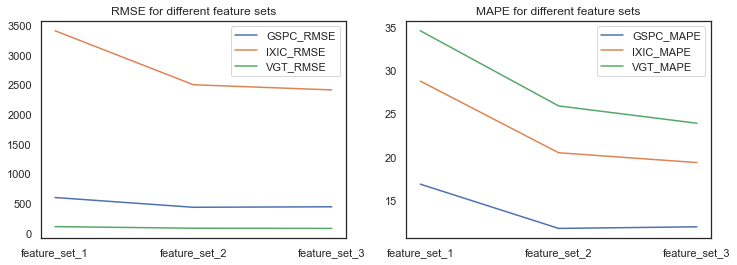

In [114]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,4))
pred_loss_df.plot(y=['GSPC_RMSE', 'IXIC_RMSE', 'VGT_RMSE'], kind="line", ax=axes[0], title="RMSE for different feature sets")
pred_loss_df.plot(y=['GSPC_MAPE', 'IXIC_MAPE', 'VGT_MAPE'], kind="line", ax=axes[1], title="MAPE for different feature sets")
plt.savefig("../plots/RMSE_MAPE_prediction.png", dpi=300)
plt.show()

### Visualise prediction results
Compare the prediction results on the different feature sets in a graphical form.
Three time series graphs, GSPC, IXIC VGT each, in each graph got three lines representing feature set 1,2,3. The fourth line is the true stock price

In [125]:
test_df_grouped = test.groupby('market_date').mean().reset_index()

In [140]:
GSPC_pred = pd.DataFrame({'market_date':test_df_grouped['market_date'],
                          'actual_GSPC':test_df_grouped['^GSPC'],
                          'set1_GSPC_pred':set1_GSPC_pred,
                          'set2_GSPC_pred':set2_GSPC_pred,
                          'set3_GSPC_pred':set3_GSPC_pred
                         }).set_index('market_date')

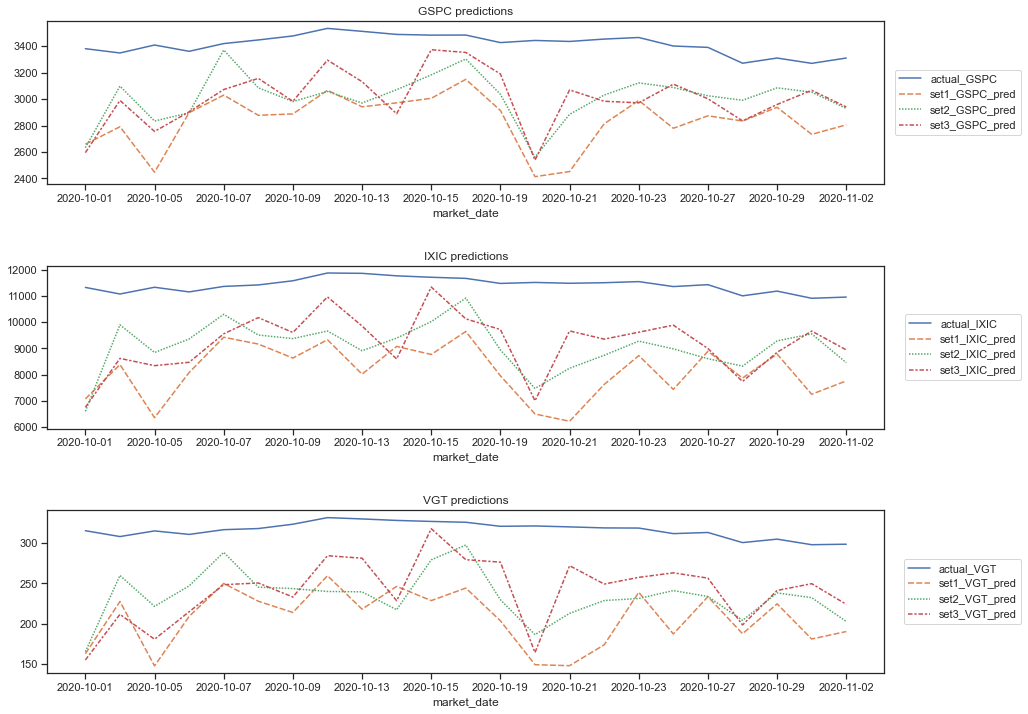

In [204]:
GSPC_pred_df, IXIC_pred_df, VGT_pred_df = plot_predictions(test,
                                                           set1_GSPC_pred, set1_IXIC_pred, set1_VGT_pred,
                                                           set2_GSPC_pred, set2_IXIC_pred, set2_VGT_pred,
                                                           set3_GSPC_pred, set3_IXIC_pred, set3_VGT_pred
                                                          )

### Compare validation and testing losses

Combine validation and testing losses dataframes into one

In [249]:
loss_summary_df = loss_df.reset_index().rename(columns={'index':'feature_set'})
loss_summary_df['category'] = 'validation'

In [250]:
loss_summary_df2 = pred_loss_df.reset_index().rename(columns={'index':'feature_set'})
loss_summary_df2['category'] = 'test'

In [251]:
loss_summary_df = pd.concat([loss_summary_df, loss_summary_df2], ignore_index=True)
loss_summary_df = loss_summary_df.melt(id_vars=['feature_set','category'], var_name='metric', value_name='loss')

In [253]:
for idx, row in loss_summary_df.iterrows():
    ticker = row['metric'].split('_')[0]
    metric = row['metric'].split('_')[1]
    loss_summary_df.loc[idx, 'ticker_symbol'] = ticker
    loss_summary_df.loc[idx, 'metric'] = metric

In [254]:
loss_summary_df

feature_set    category metric         loss ticker_symbol
0   feature_set_1  validation   RMSE   226.895757          GSPC
1   feature_set_2  validation   RMSE   222.742163          GSPC
2   feature_set_3  validation   RMSE   208.374617          GSPC
3   feature_set_1        test   RMSE   604.311217          GSPC
4   feature_set_2        test   RMSE   439.994937          GSPC
5   feature_set_3        test   RMSE   448.228351          GSPC
6   feature_set_1  validation   MAPE     5.921106          GSPC
7   feature_set_2  validation   MAPE     5.783481          GSPC
8   feature_set_3  validation   MAPE     5.701590          GSPC
9   feature_set_1        test   MAPE    16.872166          GSPC
10  feature_set_2        test   MAPE    11.737692          GSPC
11  feature_set_3        test   MAPE    11.923115          GSPC
12  feature_set_1  validation   RMSE  1017.471473          IXIC
13  feature_set_2  validation   RMSE   983.748501          IXIC
14  feature_set_3  validation   RMSE   922.641796          IXIC
15  feature_set_1        test   RMSE  3414.630240          IXIC
16  feature_set_2        test   RMSE  2504.698166          IXIC
17  feature_set_3        test   RMSE  2417.774576          IXIC
18  feature_set_1  validation   MAPE     9.296118          IXIC
19  feature_set_2  validation   MAPE     9.044359          IXIC
20  feature_set_3  validation   MAPE     8.659153          IXIC
21  feature_set_1        test   MAPE    28.827518          IXIC
22  feature_set_2        test   MAPE    20.514185          IXIC
23  feature_set_3        test   MAPE    19.375410          IXIC
24  feature_set_1  validation   RMSE    34.052712           VGT
25  feature_set_2  validation   RMSE    33.118841           VGT
26  feature_set_3  validation   RMSE    30.453157           VGT
27  feature_set_1        test   RMSE   114.074100           VGT
28  feature_set_2        test   RMSE    86.920640           VGT
29  feature_set_3        test   RMSE    83.778733           VGT
30  feature_set_1  validation   MAPE    12.919860           VGT
31  feature_set_2  validation   MAPE    12.706674           VGT
32  feature_set_3  validation   MAPE    12.226851           VGT
33  feature_set_1        test   MAPE    34.665458           VGT
34  feature_set_2        test   MAPE    25.945603           VGT
35  feature_set_3        test   MAPE    23.936391           VGT

Plot a bar chart to visualise the results

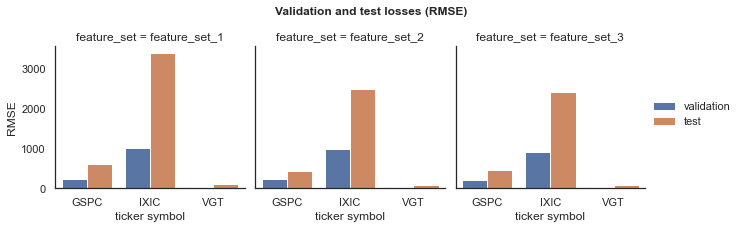

In [265]:
# RMSE
g = sns.FacetGrid(loss_summary_df[loss_summary_df['metric']=='RMSE'], col="feature_set")
g.map_dataframe(sns.barplot, x="ticker_symbol", y="loss", hue="category", palette=["C0", "C1"])
g.set_axis_labels("ticker symbol", "RMSE")
g.add_legend()
plt.subplots_adjust(top=0.8)
g.fig.suptitle('Validation and test losses (RMSE)', fontweight="bold")
plt.savefig("../plots/XGBoost_validation_test_RMSE.png", dpi=300, bbox_inches='tight')
plt.show()

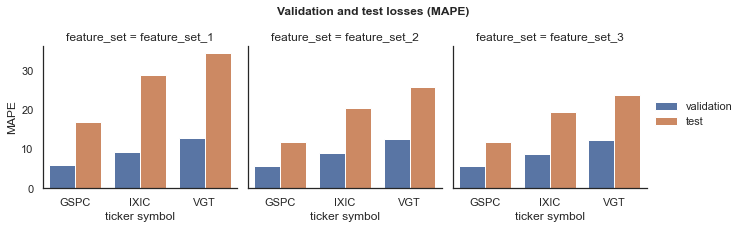

In [266]:
# MAPE
g = sns.FacetGrid(loss_summary_df[loss_summary_df['metric']=='MAPE'], col="feature_set")
g.map_dataframe(sns.barplot, x="ticker_symbol", y="loss", hue="category", palette=["C0", "C1"])
g.set_axis_labels("ticker symbol", "MAPE")
g.add_legend()
plt.subplots_adjust(top=0.8)
g.fig.suptitle('Validation and test losses (MAPE)', fontweight="bold")
plt.savefig("../plots/XGBoost_validation_test_MAPE.png", dpi=300, bbox_inches='tight')
plt.show()